# 🔥 INTRODUCTION 🔥

### Welcome to this notebook, where we will try to predict whether a horse will be able to survive based on its medical data

## List of Contents
1. IMPORT LIBRARIES
2. LOAD DATA
3. STYLE
3. EDA
4. FEATURE ENGINEERING
5. PREPROCESSING
6. MODELING
7. SUBMISSION

## 1. IMPORT LIBRARIES
***

In [1]:
import pandas as pd
import numpy as np

# Sklearn
from sklearn.preprocessing import StandardScaler, QuantileTransformer, OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score # evaluation metric used for leaderboard scoring in this competition
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Statistics
import scipy.stats as stats

# Visualization
from matplotlib import pyplot as plt # pyplot is an easy to use scripting interface for plotting as oppose to more advanced artistic interface
import matplotlib
import seaborn as sns # seaborn is even higher level graphing library built on top of matplotlib
import plotly.express as px
import plotly.subplots as tls
import plotly.graph_objects as go
from colorama import Fore, Back, Style, init

# Machine learning
import optuna # finding good hyperparameters
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 2. LOAD DATA
***

In [2]:
train = pd.read_csv('../input/playground-series-s3e22/train.csv')
test = pd.read_csv('../input/playground-series-s3e22/test.csv')
sample_submission = pd.read_csv('../input/playground-series-s3e22/sample_submission.csv')

## 3. STYLE

In [3]:
params = {'figure.figsize' : (12,8),
         'font.size' : 12,
         'axes.titlesize' : 20,
         'axes.linewidth' : 1,
         'axes.titleweight' : 'bold',
         'axes.titlecolor' : 'black'}


bbox = {'boxstyle' : 'round',
        'pad' : 0.5,
        'facecolor' : 'white',
        'edgecolor' : 'black',
        'linewidth' : 1,
        'alpha' : 1}

plt.style.use('bmh')
matplotlib.rcParams.update(params)

## 4. EDA

In [4]:
train.sample(2)

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
1199,1199,yes,adult,534491,37.9,86.0,40.0,cool,reduced,normal_pink,...,52.0,7.5,serosanguious,2.0,yes,4205,0,0,no,died
280,280,no,young,535043,38.4,56.0,68.0,warm,increased,normal_pink,...,41.0,77.0,clear,1.0,no,4300,0,0,no,lived


In [5]:
train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

**Summary of the data set "train"**

In [6]:
df_train = pd.DataFrame()
df_train['TYPES'] = train.dtypes
df_train['UNIQ_VALUE'] = train.nunique()
df_train['MISSING_VALUE'] = train.isna().sum()
df_train['MISSING_VALUE_%'] = round(df_train['MISSING_VALUE']  / train.shape[0], 4) * 100
df_train['COUNT'] = train.count() - df_train['MISSING_VALUE']
df_train

,TYPES,UNIQ_VALUE,MISSING_VALUE,MISSING_VALUE_%,COUNT
surgery,object,2,0,0.0,1235
age,object,2,0,0.0,1235
hospital_number,int64,255,0,0.0,1235
rectal_temp,float64,43,0,0.0,1235
pulse,float64,50,0,0.0,1235
respiratory_rate,float64,37,0,0.0,1235
temp_of_extremities,object,5,0,0.0,1235
peripheral_pulse,object,5,0,0.0,1235
mucous_membrane,object,7,0,0.0,1235
capillary_refill_time,object,4,0,0.0,1235


**Types of features**

In [7]:
# Categorical features
cat = train.select_dtypes(include=['object'])
print(Back.RED,'\033[1mCategorical features\033[0m')
print(cat.dtypes)

# Numerical features

# int
num_int = train.select_dtypes(include = ['int'])

# float
num_float = train.select_dtypes(include = ['float'])

print('\n',Back.RED,'\033[1mNumerical features\033[0m')
print('\033[1mint features\033[0m')
print(num_int.dtypes)
print('\n\033[1mfloat features\033[0m')
print(num_float.dtypes)

 Categorical features
surgery                  object
age                      object
temp_of_extremities      object
peripheral_pulse         object
mucous_membrane          object
capillary_refill_time    object
pain                     object
peristalsis              object
abdominal_distention     object
nasogastric_tube         object
nasogastric_reflux       object
rectal_exam_feces        object
abdomen                  object
abdomo_appearance        object
surgical_lesion          object
cp_data                  object
outcome                  object
dtype: object

  Numerical features
int features
hospital_number    int64
lesion_1           int64
lesion_2           int64
lesion_3           int64
dtype: object

float features
rectal_temp              float64
pulse                    float64
respiratory_rate         float64
nasogastric_reflux_ph    float64
packed_cell_volume       float64
total_protein            float64
abdomo_protein           float64
dtype: object


**Summary of the data set "test"**

In [8]:
df_test = pd.DataFrame()
df_test['TYPES'] = test.dtypes
df_test['UNIQ_VALUE'] = test.nunique()
df_test['MISSING_VALUE'] = test.isna().sum()
df_test['MISSING_VALUE_%'] = round(df_test['MISSING_VALUE']  / test.shape[0], 4) * 100
df_test['COUNT'] = test.count() - df_test['MISSING_VALUE']
df_test

,TYPES,UNIQ_VALUE,MISSING_VALUE,MISSING_VALUE_%,COUNT
surgery,object,2,0,0.0,824
age,object,2,0,0.0,824
hospital_number,int64,210,0,0.0,824
rectal_temp,float64,34,0,0.0,824
pulse,float64,49,0,0.0,824
respiratory_rate,float64,38,0,0.0,824
temp_of_extremities,object,5,0,0.0,824
peripheral_pulse,object,5,0,0.0,824
mucous_membrane,object,7,0,0.0,824
capillary_refill_time,object,4,0,0.0,824


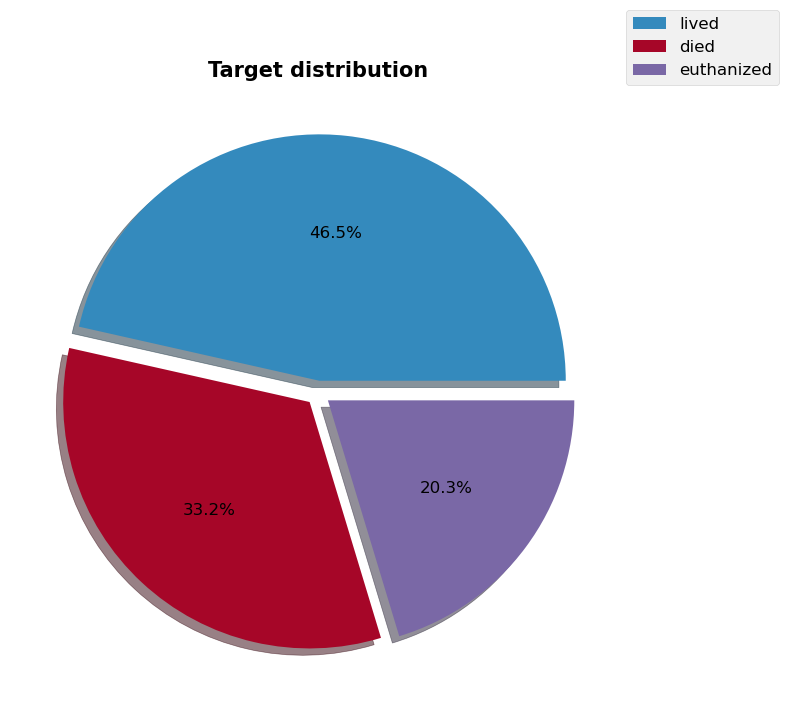

<Figure size 500x1000 with 0 Axes>

In [9]:
target_distribution = train['outcome'].value_counts()

plt.pie(target_distribution, shadow=True, explode=[.05,.05, .05], autopct='%.1f%%')

plt.title('Target distribution', size=15)
plt.legend(target_distribution.index, loc=[1.05, 1.1], bbox_to_anchor=(1, 1), fontsize=12)

plt.figure(figsize=(5,10));

**Distribution of the target variable by categorical types**

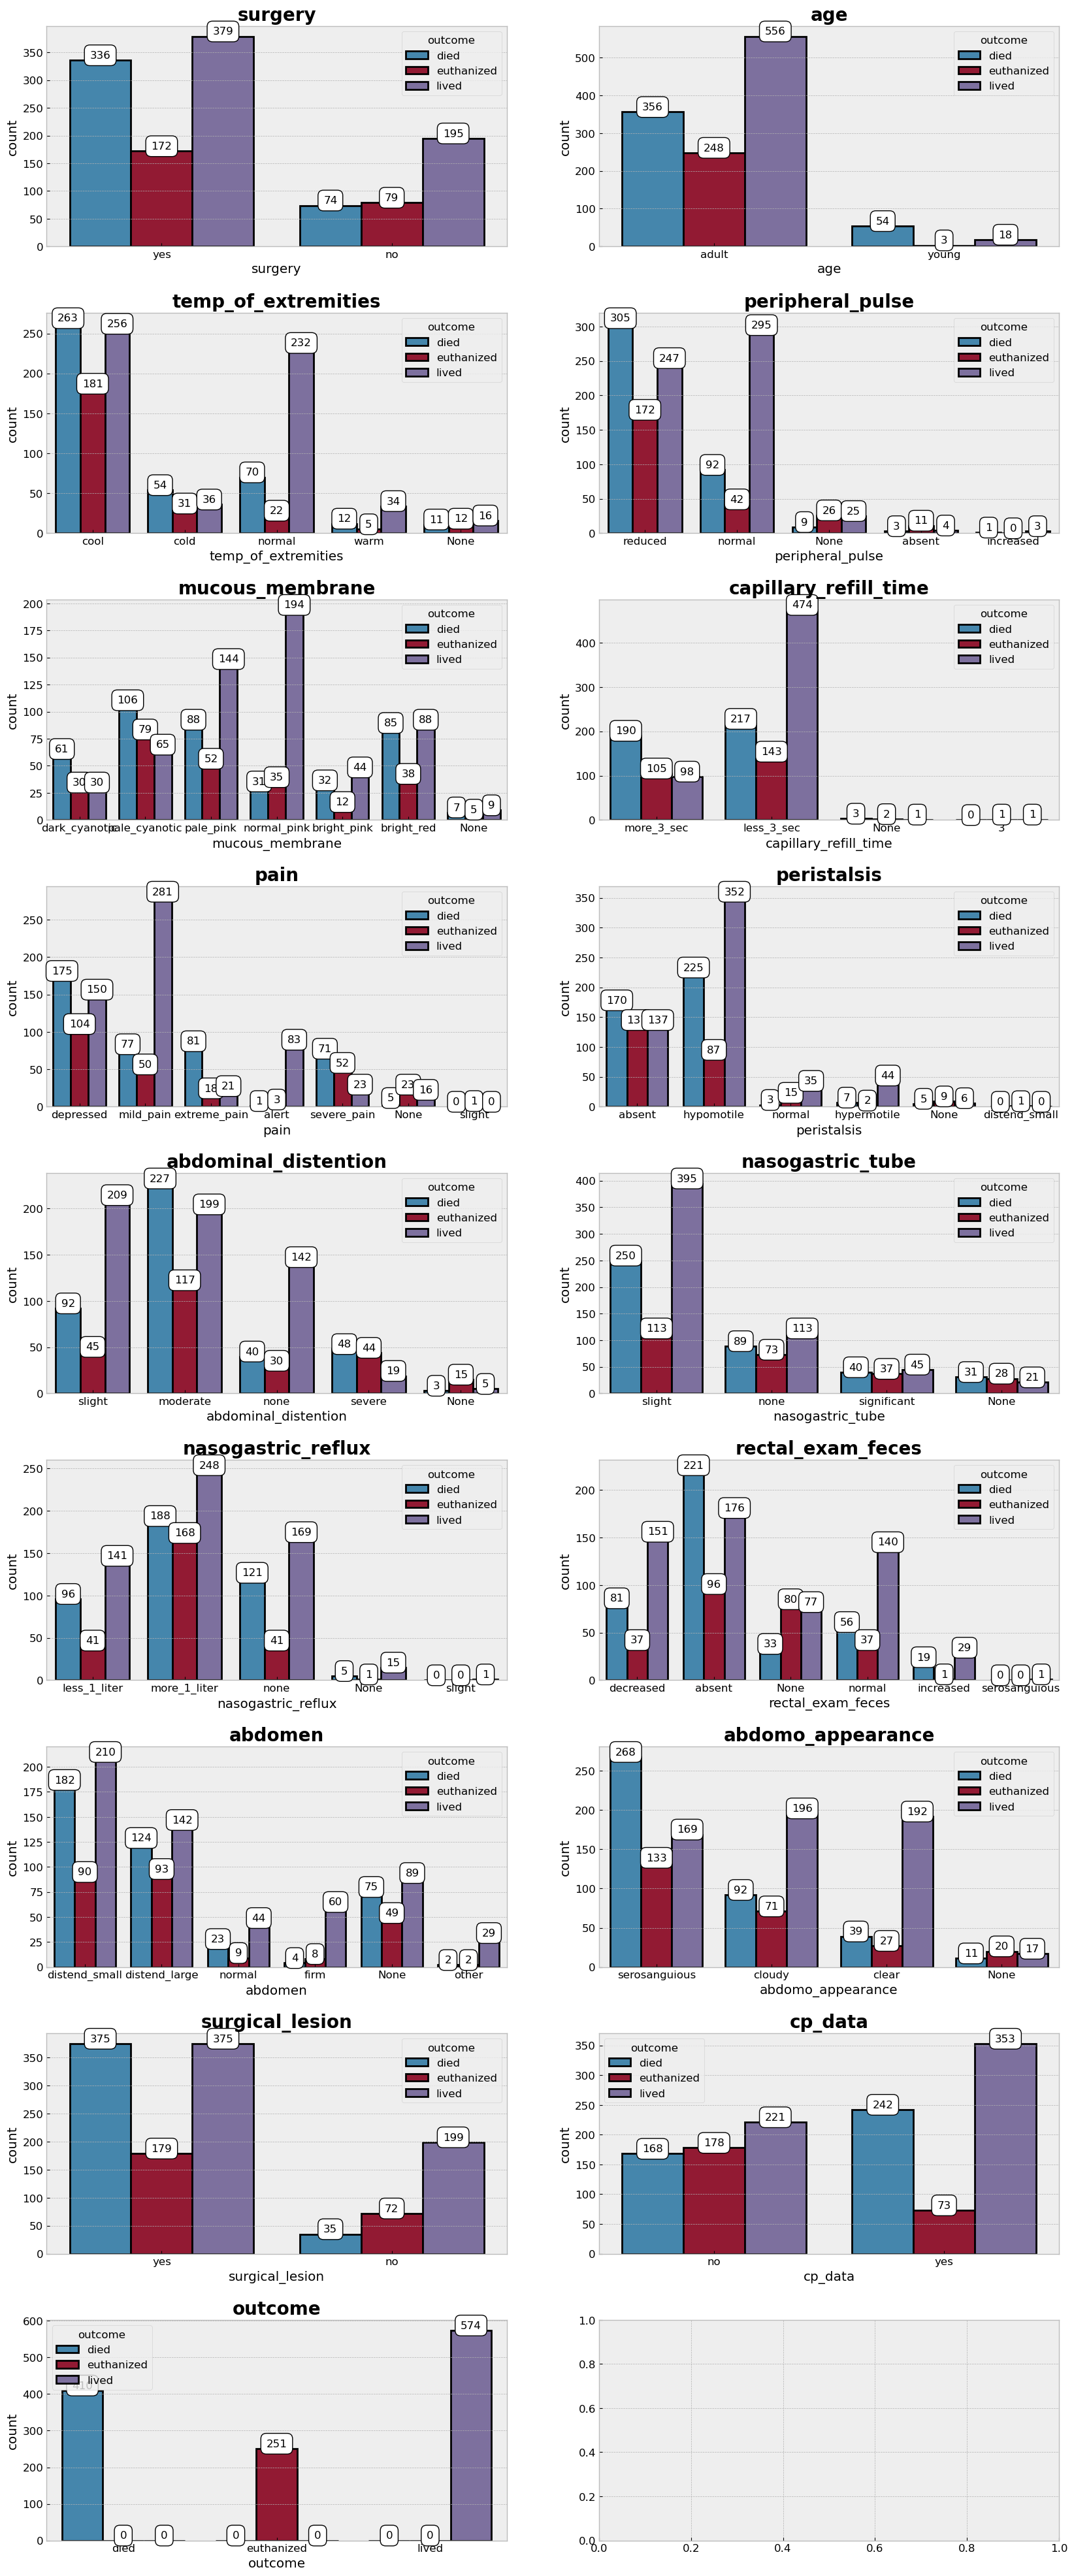

In [10]:
fig,axes = plt.subplots(9, 2, figsize = (20,50))
plt.subplots_adjust(hspace=0.3)

for i,c in enumerate(cat.columns):
    ax = axes[i//2, i%2]
    p1  = sns.countplot(data = train,
              x = c,
              hue = 'outcome',
              edgecolor = 'black',
              linewidth = 2,
              ax = ax)
    p1.bar_label(p1.containers[0], bbox = bbox)
    p1.bar_label(p1.containers[1], bbox = bbox)
    p1.bar_label(p1.containers[2], bbox = bbox)
    ax.set_title(c, fontweight= 'bold')
plt.show()

Surgery - if horses have surgery, the number of deaths among horses increases, and vice versa, if horses have not had surgery, more survive than die

Age - young horses are more likely to die

temp_of_extremities - at normal and warm emp_of_extremities, a large number of survive, while at cold emp_of_extremities about 50/50

peripheral_pulse - with a normal pulse, most of the surviving horses, while with a missing pulse, most horses are euthanized and with a reduced pulse, they die

mucous_membrane - with pale pink and normal pink mucous membranes, they have a better chance of survival than with dark cyanotic and pale cyanotic

etc..

**Distribution of the target variable by numeric columns**

In [11]:
float_list = num_float.columns.to_list()
int_list = num_int.columns.to_list()
num_list = int_list + float_list

print(f'Length of the list of numeric features = {len(num_list)}')
print('\n',num_list)

Length of the list of numeric features = 11

 ['hospital_number', 'lesion_1', 'lesion_2', 'lesion_3', 'rectal_temp', 'pulse', 'respiratory_rate', 'nasogastric_reflux_ph', 'packed_cell_volume', 'total_protein', 'abdomo_protein']


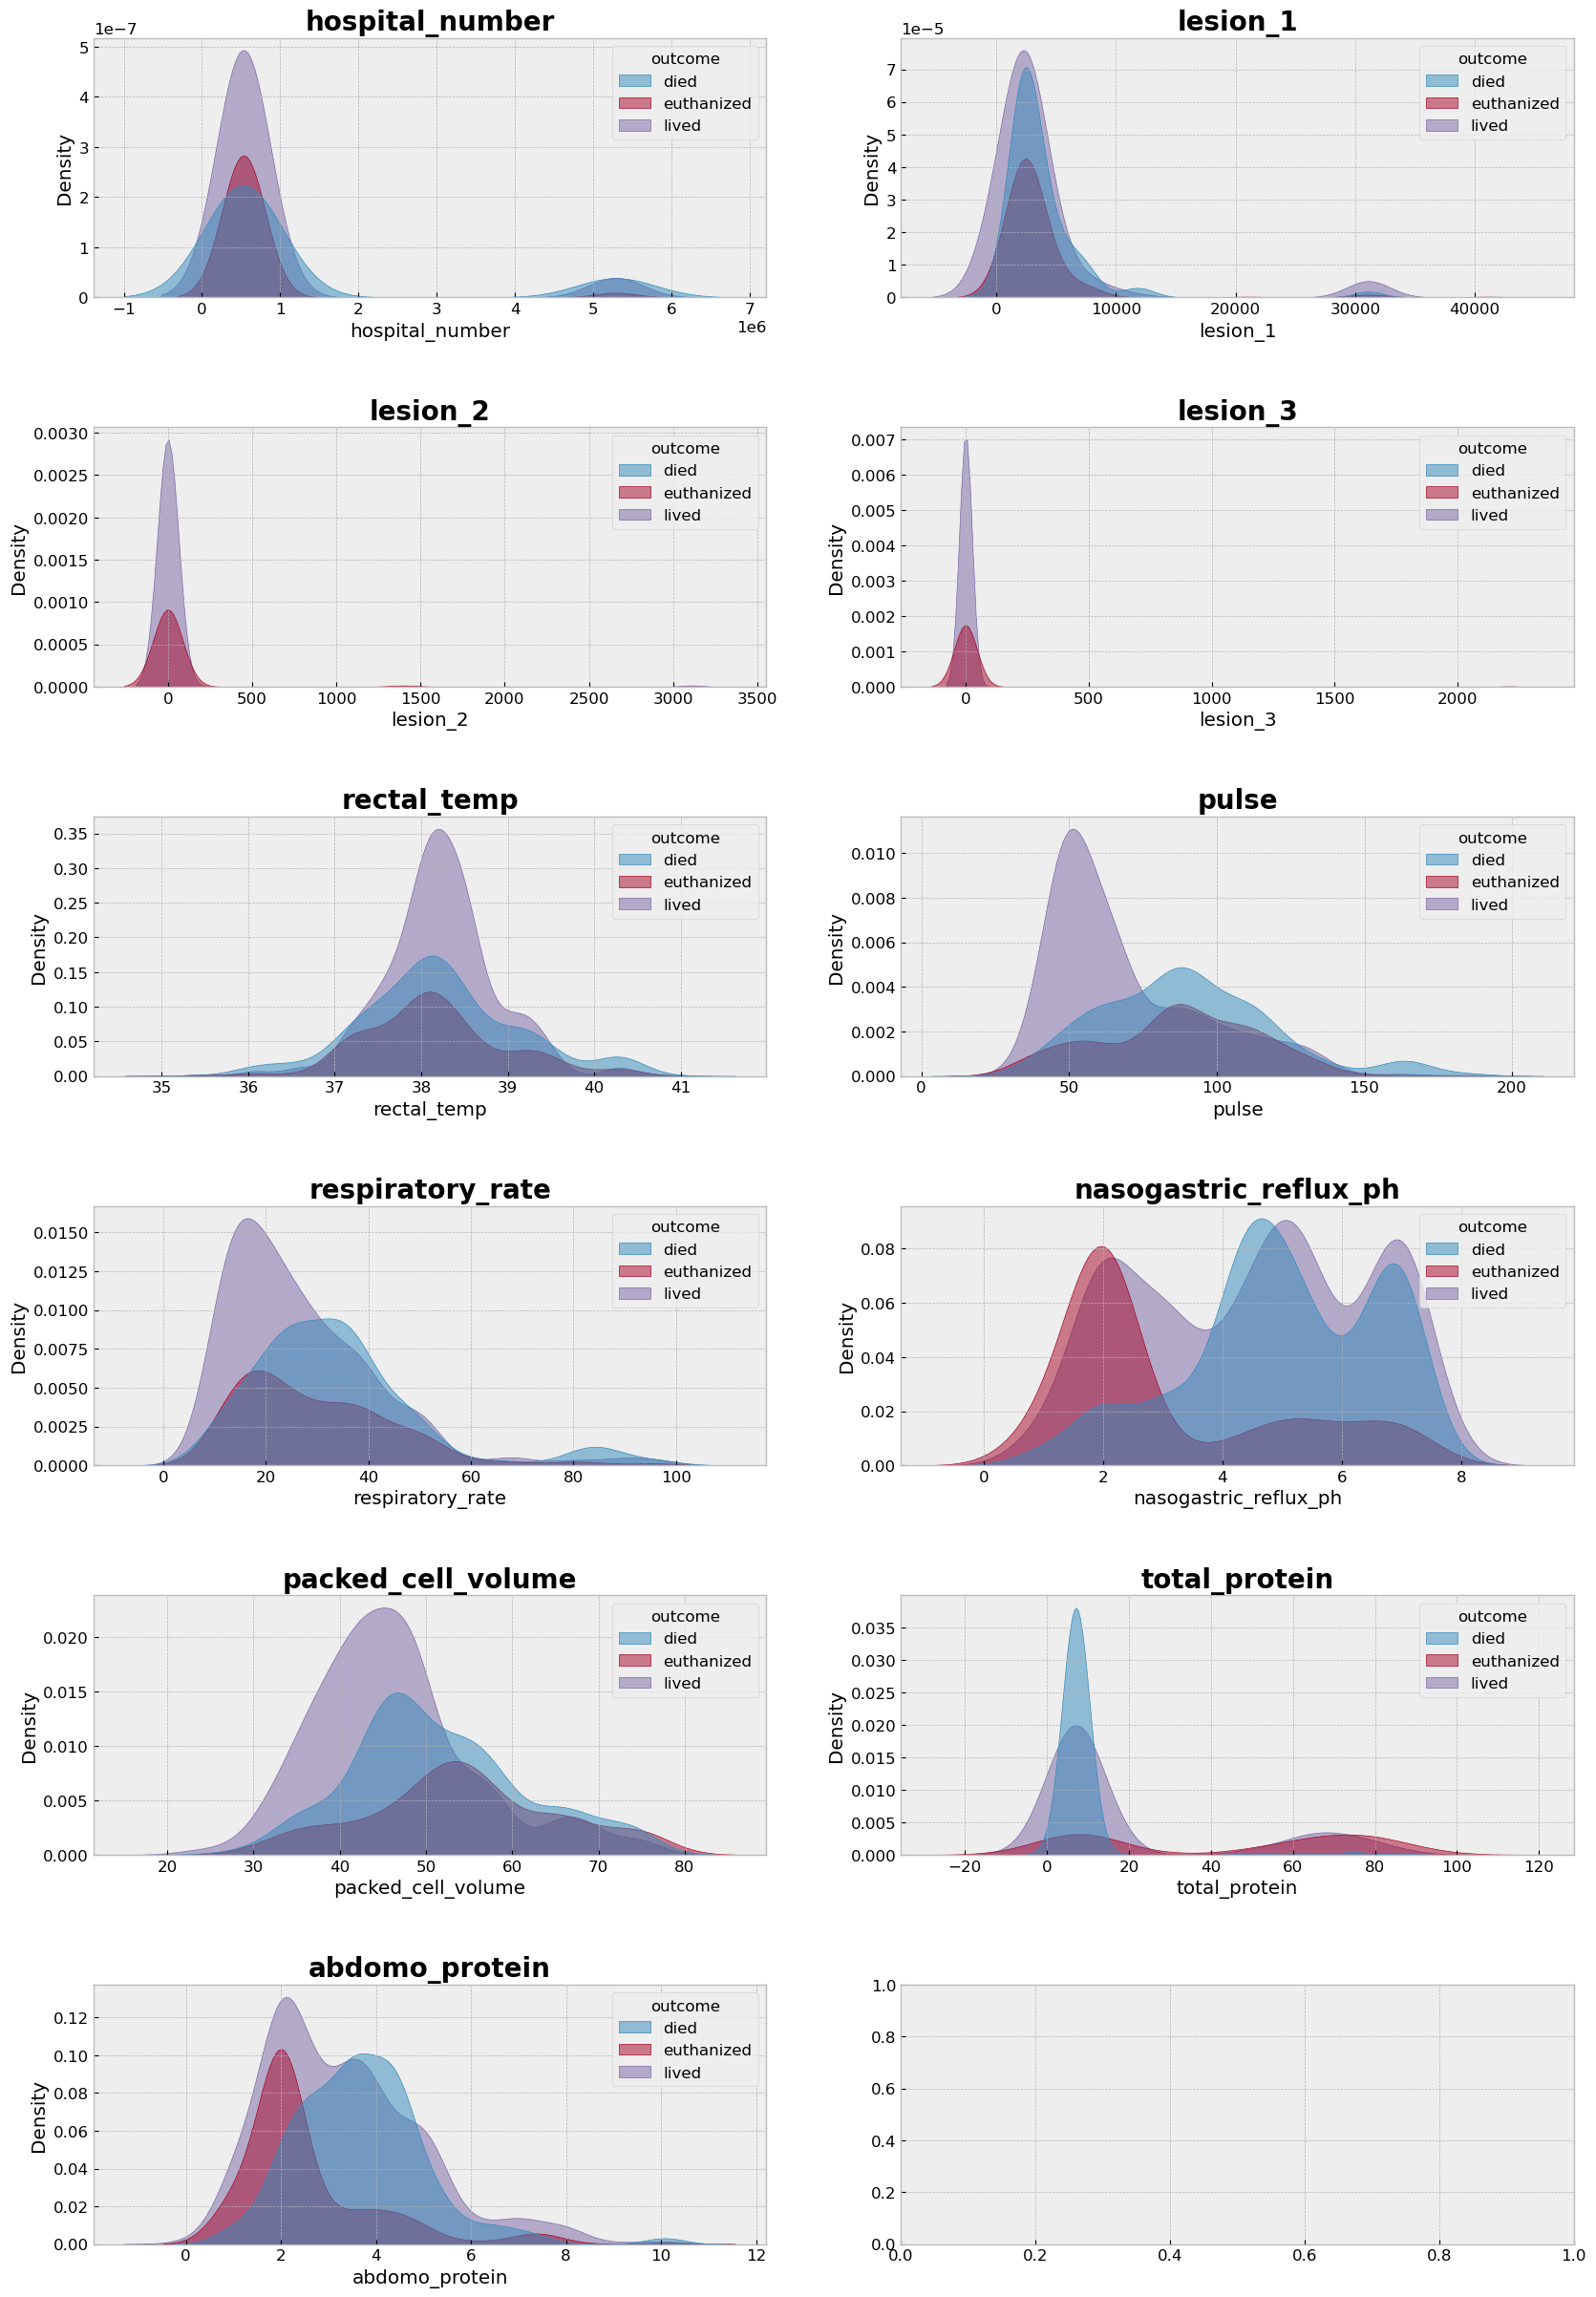

In [12]:
fig,axes = plt.subplots(6,2 ,figsize = (20,30))
plt.subplots_adjust(hspace=0.5)

for i,n in enumerate(num_list):
    ax = axes[i//2, i%2]
    sns.kdeplot(data = train,
                x = n,
                hue = 'outcome',
                ax = ax,
                alpha = 0.5, 
                fill = True,
                warn_singular=False)
    
    ax.set_title(n, fontweight= 'bold')
    

plt.show()

lesion_2 and lesion_3 do not have the died class

at a temperature of 38 degrees, the probability density is the highest for class of lived

the survivors have a pulse mostly around 50

the respiration rate of survivors is lower than that of the deceased

total_protein  - the higher the index, the more likely euthanasia is

## 5. FEATURE ENGINEERING

From the description in the original dataset, the columns lesion_1, lesion_2 and lesion_3 encode the site, type, subtype, and specific code.

In [13]:
#train['lesion_1'].value_counts()
#train['lesion_2'].value_counts()
train['lesion_3'].value_counts()

0       1233
2209       2
Name: lesion_3, dtype: int64

To begin with, we will create new columns based on the encoded information in the columns lesion_1, lesion_2 and lesion_3

In [14]:
def map_lesion_site(value:str) -> str:
    if value[:2] == "11" and len(value) == 5:
        return "all_intestinal"
    elif value[0] == "1":
        return "gastric"
    elif value[0] == "2":
        return "sm_intestine"
    elif value[0] == "3":
        return "lg_colon"
    elif value[0] == "4":
        return "lg_colon_and_cecum"
    elif value[0] == "5":
        return "cecum"
    elif value[0] == "6":
        return "transverse_colon"
    elif value[0] == "7":
        return "retum_colon"
    elif value[0] == "8":
        return "uterus"
    elif value[0] == "9":
        return "bladder"
    elif value[0] == "0":
        return '0'
    else:
        return np.nan

In [15]:
train['lesion_site'] = train['lesion_1'].astype(str).apply(map_lesion_site)
test['lesion_site'] = test['lesion_1'].astype(str).apply(map_lesion_site)

train['lesion_site_2'] = train['lesion_2'].astype(str).apply(map_lesion_site)
test['lesion_site_2'] = test['lesion_2'].astype(str).apply(map_lesion_site)

train['lesion_site_3'] = train['lesion_3'].astype(str).apply(map_lesion_site)
test['lesion_site_3'] = test['lesion_3'].astype(str).apply(map_lesion_site)

<Axes: >

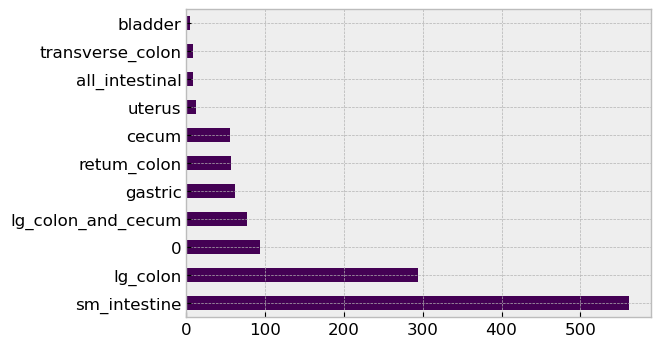

In [16]:
train['lesion_site'].value_counts().plot(kind='barh', figsize=(6,4), cmap='viridis')

<Axes: xlabel='count', ylabel='lesion_site'>

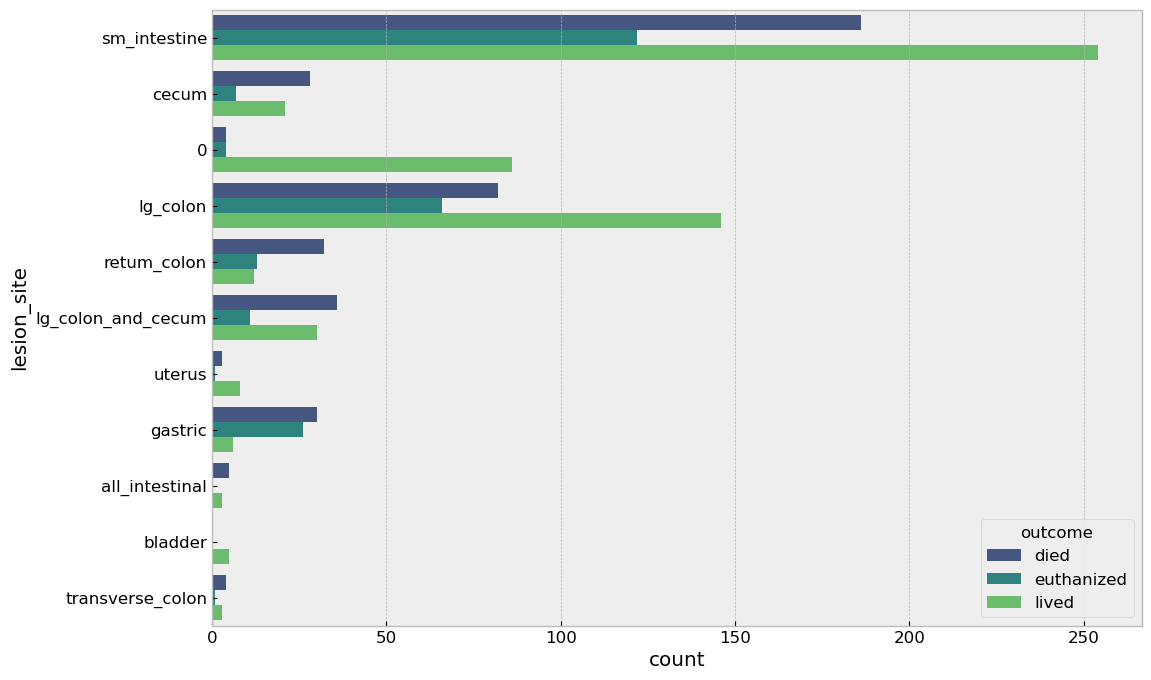

In [17]:
sns.countplot(train, y='lesion_site', hue='outcome', palette='viridis')

In [18]:
def map_lesion_type(value:str) -> str:
    if value == '0':
        return '0'

    if len(value) == 5:
        if value[:2] == '11':
            value2 = value[2]
            if value2 == '1':
                return "simple"
            elif value2 == '2':
                return 'strangulation'
            elif value2 == '3':
                return 'inflammation'
            elif value2 == '4':
                return 'other'
        else:
            value2 = value[1]
            if value2 == '1':
                return "simple"
            elif value2 == '2':
                return 'strangulation'
            elif value2 == '3':
                return 'inflammation'
            elif value2 == '4':
                return 'other'
    else:
        value2 = value[1]
        if value2 == '1':
            return "simple"
        elif value2 == '2':
            return 'strangulation'
        elif value2 == '3':
            return 'inflammation'
        elif value2 == '4':
            return 'other'
    return np.nan

In [19]:
train['lesion_type'] = train['lesion_1'].astype(str).apply(map_lesion_type)
test['lesion_type'] = test['lesion_1'].astype(str).apply(map_lesion_type)

train['lesion_type_2'] = train['lesion_2'].astype(str).apply(map_lesion_type)
test['lesion_type_2'] = test['lesion_2'].astype(str).apply(map_lesion_type)

train['lesion_type_3'] = train['lesion_3'].astype(str).apply(map_lesion_type)
test['lesion_type_3'] = test['lesion_3'].astype(str).apply(map_lesion_type)

<Axes: >

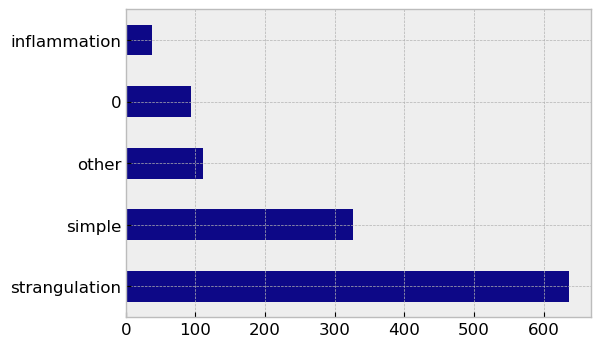

In [20]:
train['lesion_type'].value_counts().plot(kind='barh', figsize=(6,4), cmap='plasma')

<Axes: xlabel='count', ylabel='lesion_type'>

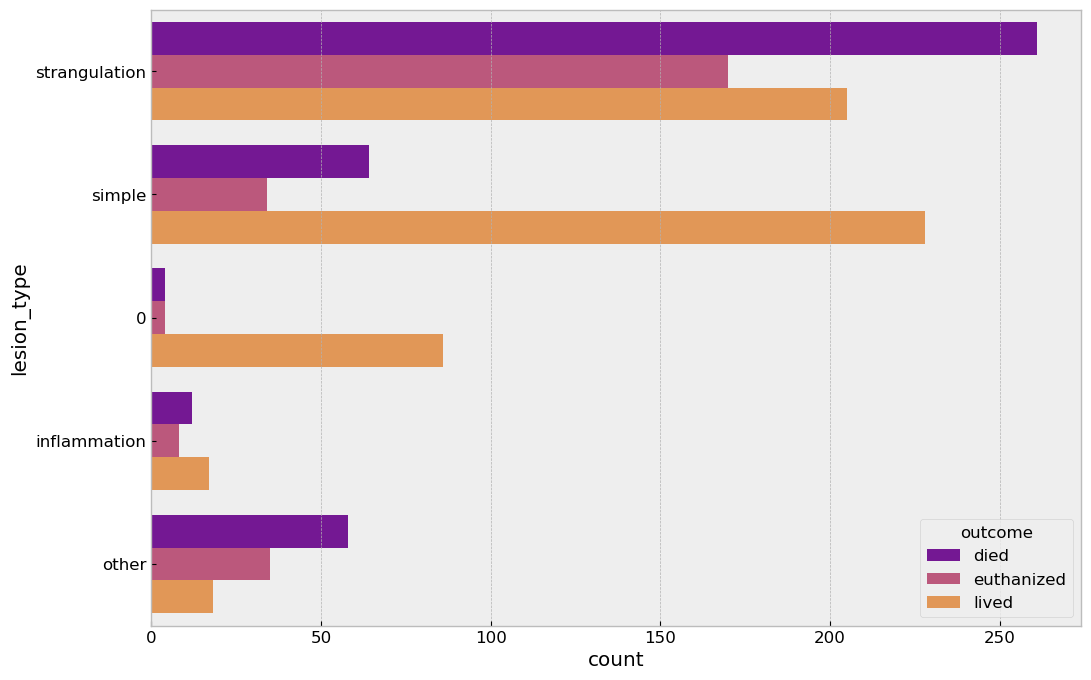

In [21]:
sns.countplot(train, y='lesion_type', hue='outcome', palette='plasma')

In [22]:
def map_lesion_subtype(value:str) -> str:
    if value == '0' or len(value) < 3:
        return '0'

    if len(value) == 5:
        if value[:2] == '11':
            value3 = value[3]
            if value3 == '1':
                return "mechanical"
            elif value3 == '2':
                return 'paralytic'
        else:
            value3 = value[2]
            if value3 == '1':
                return "mechanical"
            elif value3 == '2':
                return 'paralytic'
    else:
        value3 = value[2]
        if value3 == '1':
            return "mechanical"
        elif value3 == '2':
            return 'paralytic'
        else:
            return np.nan
    return np.nan

In [23]:
train['lesion_subtype'] = train['lesion_1'].astype(str).apply(map_lesion_subtype)
test['lesion_subtype'] = test['lesion_1'].astype(str).apply(map_lesion_subtype)

train['lesion_subtype_2'] = train['lesion_2'].astype(str).apply(map_lesion_subtype)
test['lesion_subtype_2'] = test['lesion_2'].astype(str).apply(map_lesion_subtype)

train['lesion_subtype_3'] = train['lesion_3'].astype(str).apply(map_lesion_subtype)
test['lesion_subtype_3'] = test['lesion_3'].astype(str).apply(map_lesion_subtype)

<Axes: >

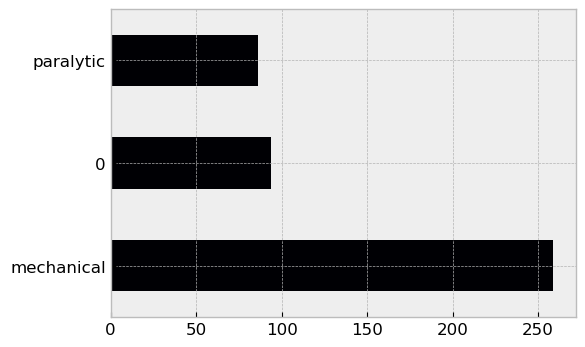

In [24]:
train['lesion_subtype'].value_counts().plot(kind='barh', figsize=(6,4), cmap='inferno')

<Axes: xlabel='count', ylabel='lesion_subtype'>

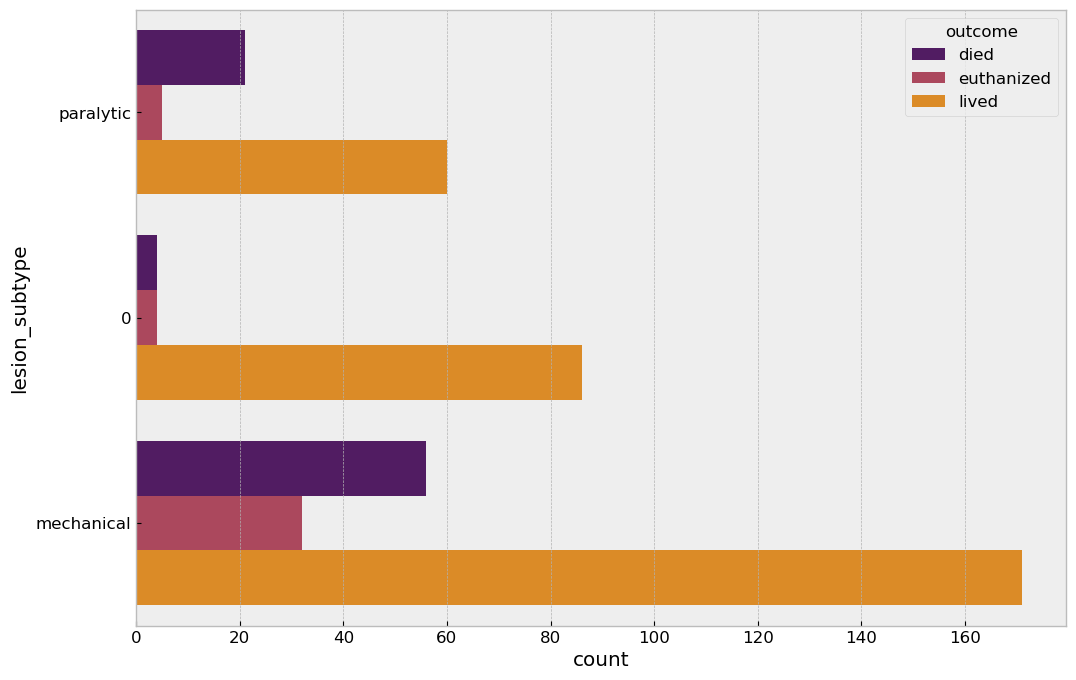

In [25]:
sns.countplot(train, y='lesion_subtype', hue='outcome', palette='inferno')

In [26]:
def map_lesion_specific_code(value:str) -> str:
    if value == '0' or len(value) < 4:
        return '0'

    if len(value) == 5:
        if value[:2] == '11':
            value4 = value[4]
            if value4 == '1':
                return "obturation"
            elif value4 == '2':
                return 'intrinsic'
            elif value4 == '3':
                return 'extrinsic'
            elif value4 == '4':
                return 'adynamic'
            elif value4 == '5':
                return 'volvulus/torsion'
            elif value4 == '6':
                return 'intussuption'
            elif value4 == '7':
                return 'thromboembolic'
            elif value4 == '8':
                return 'hernia'
            elif value4 == '9':
                return 'lipoma/slenic incarceration'
        else:
            value4 = value[3:]
            if value4 == '1':
                return "obturation"
            elif value4 == '2':
                return 'intrinsic'
            elif value4 == '3':
                return 'extrinsic'
            elif value4 == '4':
                return 'adynamic'
            elif value4 == '5':
                return 'volvulus/torsion'
            elif value4 == '6':
                return 'intussuption'
            elif value4 == '7':
                return 'thromboembolic'
            elif value4 == '8':
                return 'hernia'
            elif value4 == '9':
                return 'lipoma/slenic incarceration'
            elif value4 == '10':
                return 'displacement'
    else:
        value4 = value[3]
        if value4 == '1':
            return "obturation"
        elif value4 == '2':
            return 'intrinsic'
        elif value4 == '3':
            return 'extrinsic'
        elif value4 == '4':
            return 'adynamic'
        elif value4 == '5':
            return 'volvulus/torsion'
        elif value4 == '6':
            return 'intussuption'
        elif value4 == '7':
            return 'thromboembolic'
        elif value4 == '8':
            return 'hernia'
        elif value4 == '9':
            return 'lipoma/slenic incarceration'
        elif value4 == '10':
            return 'displacement'
    return np.nan

In [27]:
train['lesion_specific_code'] = train['lesion_1'].astype(str).apply(map_lesion_specific_code)
test['lesion_specific_code'] = test['lesion_1'].astype(str).apply(map_lesion_specific_code)

train['lesion_specific_code_2'] = train['lesion_2'].astype(str).apply(map_lesion_specific_code)
test['lesion_specific_code_2'] = test['lesion_2'].astype(str).apply(map_lesion_specific_code)

train['lesion_specific_code_3'] = train['lesion_3'].astype(str).apply(map_lesion_specific_code)
test['lesion_specific_code_3'] = test['lesion_3'].astype(str).apply(map_lesion_specific_code)

<Axes: >

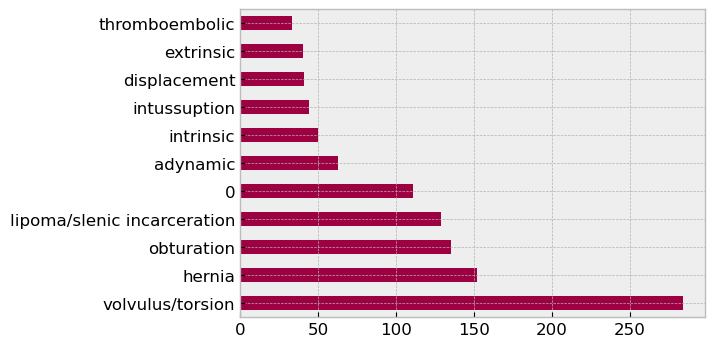

In [28]:
train['lesion_specific_code'].value_counts().plot(kind='barh', figsize=(6,4), cmap='Spectral')

<Axes: xlabel='count', ylabel='lesion_specific_code'>

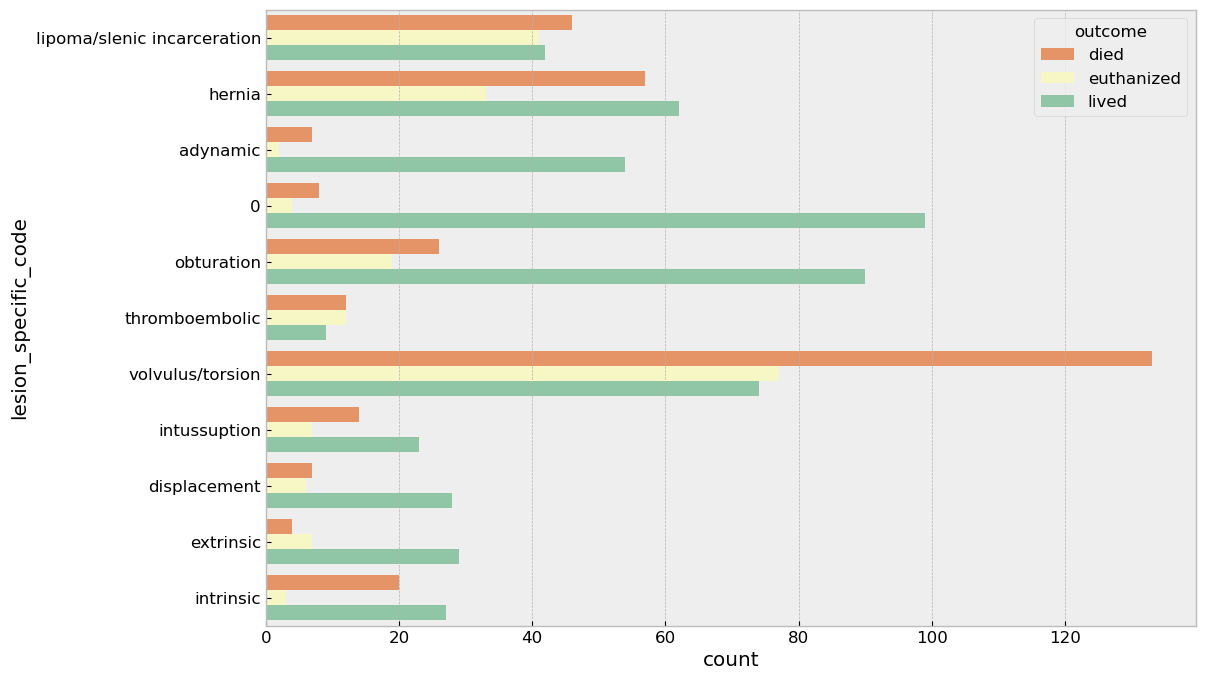

In [29]:
sns.countplot(train, y='lesion_specific_code', hue='outcome', palette='Spectral')

Delete the columns lesion_1, lesion_2, lesion_3

In [30]:
train.drop(['lesion_3', 'lesion_1', 'lesion_2'], axis=1, inplace=True)
test.drop(['lesion_3', 'lesion_1', 'lesion_2'], axis=1, inplace=True)

In [31]:
df_train = pd.DataFrame()
df_train['TYPES'] = train.dtypes
df_train['UNIQ_VALUE'] = train.nunique()
df_train['MISSING_VALUE'] = train.isna().sum()
df_train['MISSING_VALUE_%'] = round(df_train['MISSING_VALUE']  / train.shape[0], 4) * 100
df_train['COUNT'] = train.count() - df_train['MISSING_VALUE']
df_train

,TYPES,UNIQ_VALUE,MISSING_VALUE,MISSING_VALUE_%,COUNT
surgery,object,2,0,0.00,1235
age,object,2,0,0.00,1235
hospital_number,int64,255,0,0.00,1235
rectal_temp,float64,43,0,0.00,1235
pulse,float64,50,0,0.00,1235
respiratory_rate,float64,37,0,0.00,1235
temp_of_extremities,object,5,0,0.00,1235
peripheral_pulse,object,5,0,0.00,1235
mucous_membrane,object,7,0,0.00,1235
capillary_refill_time,object,4,0,0.00,1235


Delete column lesion_subtype (many missing values)

In [32]:
train.drop('lesion_subtype', axis=1, inplace=True)
test.drop('lesion_subtype', axis=1, inplace=True)

## 6. PREPROCESSING

In [33]:
X_train = train.drop(columns='outcome')
y_train = train[['outcome']]

In [34]:
numerical_pipeline = make_pipeline(
    SimpleImputer(strategy='mean'), # Tree based models like the LGBM deal with missing values better than SimpleImputer
    QuantileTransformer(output_distribution='normal', random_state=777),
    StandardScaler()
)

categorical_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OrdinalEncoder(handle_unknown='use_encoded_value' ,unknown_value=np.nan)
)

In [35]:
transformer = make_column_transformer(
    (
        numerical_pipeline,
        make_column_selector(dtype_include=np.number) # We want to apply numerical_pipeline only on numerical columns
    ),
    (
        categorical_pipeline,
        make_column_selector(dtype_include=object) # We want to apply categorical_pipeline only on object (string) columns
    ),
    remainder='passthrough', # If any column where missed then don't drop them - we take care of every column so this line is not necessery
    verbose_feature_names_out=False # if False transformer won't add prefixes (name of the transformer that generated specific feature) to column names, column names are shorter that way
)

transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('quantiletransformer',
                                                  QuantileTransformer(output_distribution='normal',
                                                                      random_state=777)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7d3ab63fe050>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7d3ab64571f0>)],
                  verbose_feature_names_out=False)

In [36]:
target_encoder = OrdinalEncoder(categories=[['died', 'euthanized', 'lived']])

In [37]:
X_train = transformer.fit_transform(X_train)
y_train = target_encoder.fit_transform(y_train).ravel()

In [38]:
X_train = pd.DataFrame(data=X_train, columns=transformer.get_feature_names_out(), index=train.index)
X_train.head()

,hospital_number,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,surgery,age,...,lesion_site_2,lesion_site_3,lesion_type,lesion_type_2,lesion_type_3,lesion_subtype_2,lesion_subtype_3,lesion_specific_code,lesion_specific_code_2,lesion_specific_code_3
0,0.105878,-0.109224,1.700853,-0.187200,0.602077,0.558758,0.532677,0.118752,1.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0
1,0.492654,-0.950993,0.350477,-1.401771,-0.658106,-1.490259,0.920788,-0.774723,1.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
2,0.040881,0.252304,1.294186,0.031250,-0.196908,-1.022449,-0.940529,0.118752,1.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.318004,-1.563261,-0.081099,0.163864,-0.658106,0.292826,-0.400509,0.463496,1.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
4,2.417133,-0.336523,-0.782074,1.073563,0.936927,-0.189014,-0.175523,-0.231932,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 7. MODELING

In [39]:
X_train_optuna, X_val_optuna, y_train_optuna, y_val_optuna = train_test_split(X_train, y_train, train_size=0.8, random_state=777)

In [40]:
def objective(trial):
    # model = LGBMClassifier(
    #     n_estimators = trial.suggest_int('n_estimators', 32, 1024),
    #     learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5),
    #     max_depth = trial.suggest_int('max_depth', 1, 10),
    #     num_leaves = trial.suggest_int('num_leaves', 2, 1024),
    #     reg_lambda  = trial.suggest_float('reg_lambda', 0.001, 10),
    #     reg_alpha = trial.suggest_float('reg_alpha', 0, 10),
    #     subsample = trial.suggest_float('subsample', 0.001, 1),
    #     colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1),
    #     min_child_samples = trial.suggest_int('min_child_samples', 2, 1024),
    #     min_child_weight = trial.suggest_int('min_child_weight', 1, 10),
    #     objective = trial.suggest_categorical('objective', ['multiclass']),
    #     metric = trial.suggest_categorical('metric', ['multi_logloss']),
    #     random_state = trial.suggest_categorical('random_state', [777]),
    #     boosting_type = trial.suggest_categorical('boosting_type', ["gbdt", "dart", "goss"]),
    # )

#     model = CatBoostClassifier(
#         iterations = trial.suggest_int('iterations', 32, 1024),
#         learning_rate = trial.suggest_float('learning_rate', 0.001, 0.3),
#         depth = trial.suggest_int('depth', 1, 10),
#         l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 0.01, 10),
#         grow_policy = trial.suggest_categorical('grow_policy', ['Depthwise']),
#         bootstrap_type = trial.suggest_categorical('bootstrap_type', ['Bayesian']),
#         od_type = trial.suggest_categorical('od_type', ['Iter']),
#         eval_metric = trial.suggest_categorical('eval_metric', ['TotalF1']),
#         loss_function = trial.suggest_categorical('loss_function', ['MultiClass']),
#         random_state = trial.suggest_categorical('random_state', [777]),
#         verbose = trial.suggest_categorical('verbose', [0])
#     )

    model = XGBClassifier(
        eta = trial.suggest_float('eta', 0.001, 0.3),
        n_estimators = trial.suggest_int('n_estimators', 32, 1024),
        max_depth = trial.suggest_int('max_depth', 1, 10),
        reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10),
        subsample = trial.suggest_float('subsample', 0.01, 1),
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10),
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.01, 1),
        random_state = trial.suggest_categorical('random_state', [777]),
        objective = trial.suggest_categorical('objective', ['multi:softmax'])
    )

    model.fit(
        X_train_optuna, y_train_optuna,
        eval_set=[(X_train_optuna, y_train_optuna), (X_val_optuna, y_val_optuna)],
        #verbose=False
    )

    return f1_score(y_val_optuna, model.predict(X_val_optuna), average='micro') # micro F1 is used in this competitons for evaluation so we will use it for hyperparameter optimization

In [41]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_hyperparams = study.best_params
best_hyperparams

[I 2023-10-03 20:05:45,787] A new study created in memory with name: no-name-fa939f20-d622-4a14-a202-022d1d4572c2


[0]	validation_0-mlogloss:1.00486	validation_1-mlogloss:1.01581
[1]	validation_0-mlogloss:0.93038	validation_1-mlogloss:0.95307
[2]	validation_0-mlogloss:0.87059	validation_1-mlogloss:0.90261
[3]	validation_0-mlogloss:0.82140	validation_1-mlogloss:0.86000
[4]	validation_0-mlogloss:0.77894	validation_1-mlogloss:0.82983
[5]	validation_0-mlogloss:0.74554	validation_1-mlogloss:0.80771
[6]	validation_0-mlogloss:0.71850	validation_1-mlogloss:0.78898
[7]	validation_0-mlogloss:0.69338	validation_1-mlogloss:0.77780
[8]	validation_0-mlogloss:0.67570	validation_1-mlogloss:0.76876
[9]	validation_0-mlogloss:0.65602	validation_1-mlogloss:0.76087
[10]	validation_0-mlogloss:0.63839	validation_1-mlogloss:0.74998
[11]	validation_0-mlogloss:0.62385	validation_1-mlogloss:0.74140
[12]	validation_0-mlogloss:0.60824	validation_1-mlogloss:0.73618
[13]	validation_0-mlogloss:0.59577	validation_1-mlogloss:0.72862
[14]	validation_0-mlogloss:0.58405	validation_1-mlogloss:0.72684
[15]	validation_0-mlogloss:0.57344	

[I 2023-10-03 20:05:46,207] Trial 0 finished with value: 0.7246963562753036 and parameters: {'eta': 0.2226541636963378, 'n_estimators': 96, 'max_depth': 4, 'reg_lambda': 7.003511679076663, 'subsample': 0.7394397245101, 'min_child_weight': 7, 'colsample_bytree': 0.6851251193675653, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 0 with value: 0.7246963562753036.


[0]	validation_0-mlogloss:1.06459	validation_1-mlogloss:1.07033
[1]	validation_0-mlogloss:1.01526	validation_1-mlogloss:1.02812
[2]	validation_0-mlogloss:0.97742	validation_1-mlogloss:0.99920
[3]	validation_0-mlogloss:0.94560	validation_1-mlogloss:0.97231
[4]	validation_0-mlogloss:0.91727	validation_1-mlogloss:0.94934
[5]	validation_0-mlogloss:0.88835	validation_1-mlogloss:0.92447
[6]	validation_0-mlogloss:0.86385	validation_1-mlogloss:0.90792
[7]	validation_0-mlogloss:0.83822	validation_1-mlogloss:0.88994
[8]	validation_0-mlogloss:0.81682	validation_1-mlogloss:0.87359
[9]	validation_0-mlogloss:0.79423	validation_1-mlogloss:0.85869
[10]	validation_0-mlogloss:0.77470	validation_1-mlogloss:0.84347
[11]	validation_0-mlogloss:0.76312	validation_1-mlogloss:0.83378
[12]	validation_0-mlogloss:0.74952	validation_1-mlogloss:0.82406
[13]	validation_0-mlogloss:0.73657	validation_1-mlogloss:0.81267
[14]	validation_0-mlogloss:0.72405	validation_1-mlogloss:0.80655
[15]	validation_0-mlogloss:0.70978	

[I 2023-10-03 20:05:46,556] Trial 1 finished with value: 0.7165991902834008 and parameters: {'eta': 0.12764071755033335, 'n_estimators': 73, 'max_depth': 6, 'reg_lambda': 9.864164725027306, 'subsample': 0.7320665473167279, 'min_child_weight': 8, 'colsample_bytree': 0.2694840623561424, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 0 with value: 0.7246963562753036.


[0]	validation_0-mlogloss:1.02890	validation_1-mlogloss:1.04813
[1]	validation_0-mlogloss:0.96219	validation_1-mlogloss:1.00134
[2]	validation_0-mlogloss:0.90815	validation_1-mlogloss:0.96584
[3]	validation_0-mlogloss:0.85625	validation_1-mlogloss:0.92791
[4]	validation_0-mlogloss:0.81357	validation_1-mlogloss:0.89686
[5]	validation_0-mlogloss:0.77056	validation_1-mlogloss:0.86633
[6]	validation_0-mlogloss:0.73511	validation_1-mlogloss:0.84987
[7]	validation_0-mlogloss:0.69991	validation_1-mlogloss:0.82951
[8]	validation_0-mlogloss:0.66892	validation_1-mlogloss:0.80998
[9]	validation_0-mlogloss:0.64237	validation_1-mlogloss:0.79421
[10]	validation_0-mlogloss:0.61531	validation_1-mlogloss:0.77930
[11]	validation_0-mlogloss:0.59593	validation_1-mlogloss:0.76756
[12]	validation_0-mlogloss:0.57641	validation_1-mlogloss:0.75571
[13]	validation_0-mlogloss:0.55792	validation_1-mlogloss:0.74752
[14]	validation_0-mlogloss:0.54094	validation_1-mlogloss:0.74354
[15]	validation_0-mlogloss:0.52200	

[I 2023-10-03 20:05:49,195] Trial 2 finished with value: 0.7125506072874493 and parameters: {'eta': 0.14952570426047604, 'n_estimators': 511, 'max_depth': 9, 'reg_lambda': 6.704943036646307, 'subsample': 0.6962323568952324, 'min_child_weight': 1, 'colsample_bytree': 0.45278760221442393, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 0 with value: 0.7246963562753036.


[0]	validation_0-mlogloss:1.07193	validation_1-mlogloss:1.07569
[1]	validation_0-mlogloss:1.04637	validation_1-mlogloss:1.05381
[2]	validation_0-mlogloss:1.03630	validation_1-mlogloss:1.04427
[3]	validation_0-mlogloss:1.02225	validation_1-mlogloss:1.03064
[4]	validation_0-mlogloss:0.99197	validation_1-mlogloss:0.99803
[5]	validation_0-mlogloss:0.97266	validation_1-mlogloss:0.97492
[6]	validation_0-mlogloss:0.94548	validation_1-mlogloss:0.95108
[7]	validation_0-mlogloss:0.93949	validation_1-mlogloss:0.94549
[8]	validation_0-mlogloss:0.91888	validation_1-mlogloss:0.92754
[9]	validation_0-mlogloss:0.88753	validation_1-mlogloss:0.90341
[10]	validation_0-mlogloss:0.87784	validation_1-mlogloss:0.89735
[11]	validation_0-mlogloss:0.86640	validation_1-mlogloss:0.88873
[12]	validation_0-mlogloss:0.86625	validation_1-mlogloss:0.88845
[13]	validation_0-mlogloss:0.85740	validation_1-mlogloss:0.88055
[14]	validation_0-mlogloss:0.84931	validation_1-mlogloss:0.87481
[15]	validation_0-mlogloss:0.84888	

[I 2023-10-03 20:05:51,992] Trial 3 finished with value: 0.7327935222672065 and parameters: {'eta': 0.26179350624464975, 'n_estimators': 953, 'max_depth': 8, 'reg_lambda': 5.879233994966257, 'subsample': 0.2529177404261494, 'min_child_weight': 8, 'colsample_bytree': 0.04674766618986065, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 3 with value: 0.7327935222672065.


[0]	validation_0-mlogloss:1.03096	validation_1-mlogloss:1.04353
[1]	validation_0-mlogloss:0.97687	validation_1-mlogloss:0.99992
[2]	validation_0-mlogloss:0.92842	validation_1-mlogloss:0.95674
[3]	validation_0-mlogloss:0.88672	validation_1-mlogloss:0.91957
[4]	validation_0-mlogloss:0.84921	validation_1-mlogloss:0.89187
[5]	validation_0-mlogloss:0.81839	validation_1-mlogloss:0.87077
[6]	validation_0-mlogloss:0.78890	validation_1-mlogloss:0.85365
[7]	validation_0-mlogloss:0.76584	validation_1-mlogloss:0.83478
[8]	validation_0-mlogloss:0.74408	validation_1-mlogloss:0.82243
[9]	validation_0-mlogloss:0.72434	validation_1-mlogloss:0.81060
[10]	validation_0-mlogloss:0.71059	validation_1-mlogloss:0.80334
[11]	validation_0-mlogloss:0.69573	validation_1-mlogloss:0.79037
[12]	validation_0-mlogloss:0.68175	validation_1-mlogloss:0.78106
[13]	validation_0-mlogloss:0.67072	validation_1-mlogloss:0.77480
[14]	validation_0-mlogloss:0.65895	validation_1-mlogloss:0.77431
[15]	validation_0-mlogloss:0.65030	

[I 2023-10-03 20:05:55,204] Trial 4 finished with value: 0.708502024291498 and parameters: {'eta': 0.16676772389531333, 'n_estimators': 865, 'max_depth': 7, 'reg_lambda': 2.8223643446641686, 'subsample': 0.19897810029937185, 'min_child_weight': 5, 'colsample_bytree': 0.9409439004187644, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 3 with value: 0.7327935222672065.


[0]	validation_0-mlogloss:1.04373	validation_1-mlogloss:1.05324
[1]	validation_0-mlogloss:0.99285	validation_1-mlogloss:1.00375
[2]	validation_0-mlogloss:0.95020	validation_1-mlogloss:0.96220
[3]	validation_0-mlogloss:0.91493	validation_1-mlogloss:0.93193
[4]	validation_0-mlogloss:0.88144	validation_1-mlogloss:0.90206
[5]	validation_0-mlogloss:0.84606	validation_1-mlogloss:0.87244
[6]	validation_0-mlogloss:0.81839	validation_1-mlogloss:0.86137
[7]	validation_0-mlogloss:0.78871	validation_1-mlogloss:0.84005
[8]	validation_0-mlogloss:0.76432	validation_1-mlogloss:0.82594
[9]	validation_0-mlogloss:0.74252	validation_1-mlogloss:0.81060
[10]	validation_0-mlogloss:0.72682	validation_1-mlogloss:0.80341
[11]	validation_0-mlogloss:0.71025	validation_1-mlogloss:0.78788
[12]	validation_0-mlogloss:0.69883	validation_1-mlogloss:0.78022
[13]	validation_0-mlogloss:0.68653	validation_1-mlogloss:0.77760
[14]	validation_0-mlogloss:0.67487	validation_1-mlogloss:0.78030
[15]	validation_0-mlogloss:0.66700	

[I 2023-10-03 20:05:56,733] Trial 5 finished with value: 0.6923076923076923 and parameters: {'eta': 0.1413977495183876, 'n_estimators': 388, 'max_depth': 9, 'reg_lambda': 1.0469695589892163, 'subsample': 0.1209882312282774, 'min_child_weight': 2, 'colsample_bytree': 0.9728789675737355, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 3 with value: 0.7327935222672065.


[0]	validation_0-mlogloss:1.02640	validation_1-mlogloss:1.04183
[1]	validation_0-mlogloss:0.96559	validation_1-mlogloss:0.98607
[2]	validation_0-mlogloss:0.91721	validation_1-mlogloss:0.94426
[3]	validation_0-mlogloss:0.87314	validation_1-mlogloss:0.90768
[4]	validation_0-mlogloss:0.83719	validation_1-mlogloss:0.87792
[5]	validation_0-mlogloss:0.80622	validation_1-mlogloss:0.85376
[6]	validation_0-mlogloss:0.78048	validation_1-mlogloss:0.83585
[7]	validation_0-mlogloss:0.75873	validation_1-mlogloss:0.81847
[8]	validation_0-mlogloss:0.73952	validation_1-mlogloss:0.80298
[9]	validation_0-mlogloss:0.72348	validation_1-mlogloss:0.78890
[10]	validation_0-mlogloss:0.70476	validation_1-mlogloss:0.77776
[11]	validation_0-mlogloss:0.68947	validation_1-mlogloss:0.76976
[12]	validation_0-mlogloss:0.67546	validation_1-mlogloss:0.76257
[13]	validation_0-mlogloss:0.66275	validation_1-mlogloss:0.75714
[14]	validation_0-mlogloss:0.65222	validation_1-mlogloss:0.75421
[15]	validation_0-mlogloss:0.64237	

[I 2023-10-03 20:05:57,844] Trial 6 finished with value: 0.6882591093117408 and parameters: {'eta': 0.16993655782655626, 'n_estimators': 314, 'max_depth': 3, 'reg_lambda': 3.4530198960106286, 'subsample': 0.5780411073899814, 'min_child_weight': 6, 'colsample_bytree': 0.8074005169422984, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 3 with value: 0.7327935222672065.


[0]	validation_0-mlogloss:1.06084	validation_1-mlogloss:1.06327
[1]	validation_0-mlogloss:1.02580	validation_1-mlogloss:1.03330
[2]	validation_0-mlogloss:1.01423	validation_1-mlogloss:1.02170
[3]	validation_0-mlogloss:1.00319	validation_1-mlogloss:1.01184
[4]	validation_0-mlogloss:0.96812	validation_1-mlogloss:0.97519
[5]	validation_0-mlogloss:0.94719	validation_1-mlogloss:0.95325
[6]	validation_0-mlogloss:0.91786	validation_1-mlogloss:0.93499
[7]	validation_0-mlogloss:0.91205	validation_1-mlogloss:0.92920
[8]	validation_0-mlogloss:0.88799	validation_1-mlogloss:0.91014
[9]	validation_0-mlogloss:0.84920	validation_1-mlogloss:0.88614
[10]	validation_0-mlogloss:0.83799	validation_1-mlogloss:0.87755
[11]	validation_0-mlogloss:0.82371	validation_1-mlogloss:0.86635
[12]	validation_0-mlogloss:0.82248	validation_1-mlogloss:0.86503
[13]	validation_0-mlogloss:0.81406	validation_1-mlogloss:0.85758
[14]	validation_0-mlogloss:0.80415	validation_1-mlogloss:0.85075
[15]	validation_0-mlogloss:0.80347	

[I 2023-10-03 20:06:01,514] Trial 7 finished with value: 0.6963562753036437 and parameters: {'eta': 0.26820817716753076, 'n_estimators': 1014, 'max_depth': 10, 'reg_lambda': 4.583953721886047, 'subsample': 0.714092502745377, 'min_child_weight': 8, 'colsample_bytree': 0.034098742926662824, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 3 with value: 0.7327935222672065.


[0]	validation_0-mlogloss:1.07362	validation_1-mlogloss:1.07432
[1]	validation_0-mlogloss:1.03237	validation_1-mlogloss:1.03791
[2]	validation_0-mlogloss:1.00306	validation_1-mlogloss:1.01471
[3]	validation_0-mlogloss:0.98150	validation_1-mlogloss:0.99785
[4]	validation_0-mlogloss:0.95820	validation_1-mlogloss:0.97774
[5]	validation_0-mlogloss:0.93652	validation_1-mlogloss:0.95764
[6]	validation_0-mlogloss:0.91561	validation_1-mlogloss:0.94240
[7]	validation_0-mlogloss:0.90217	validation_1-mlogloss:0.93215
[8]	validation_0-mlogloss:0.88687	validation_1-mlogloss:0.92008
[9]	validation_0-mlogloss:0.86203	validation_1-mlogloss:0.90391
[10]	validation_0-mlogloss:0.84714	validation_1-mlogloss:0.89100
[11]	validation_0-mlogloss:0.83562	validation_1-mlogloss:0.88116
[12]	validation_0-mlogloss:0.82425	validation_1-mlogloss:0.87195
[13]	validation_0-mlogloss:0.80906	validation_1-mlogloss:0.85970
[14]	validation_0-mlogloss:0.79969	validation_1-mlogloss:0.85354
[15]	validation_0-mlogloss:0.78885	

[I 2023-10-03 20:06:02,619] Trial 8 finished with value: 0.728744939271255 and parameters: {'eta': 0.12660099163408609, 'n_estimators': 320, 'max_depth': 8, 'reg_lambda': 9.343656420898617, 'subsample': 0.4671184359324471, 'min_child_weight': 3, 'colsample_bytree': 0.12795106190691208, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 3 with value: 0.7327935222672065.


[0]	validation_0-mlogloss:1.09215	validation_1-mlogloss:1.09254
[1]	validation_0-mlogloss:1.08308	validation_1-mlogloss:1.08417
[2]	validation_0-mlogloss:1.07456	validation_1-mlogloss:1.07746
[3]	validation_0-mlogloss:1.06842	validation_1-mlogloss:1.07205
[4]	validation_0-mlogloss:1.06063	validation_1-mlogloss:1.06492
[5]	validation_0-mlogloss:1.05318	validation_1-mlogloss:1.05758
[6]	validation_0-mlogloss:1.04553	validation_1-mlogloss:1.05107
[7]	validation_0-mlogloss:1.03974	validation_1-mlogloss:1.04577
[8]	validation_0-mlogloss:1.03350	validation_1-mlogloss:1.04014
[9]	validation_0-mlogloss:1.02451	validation_1-mlogloss:1.03274
[10]	validation_0-mlogloss:1.01754	validation_1-mlogloss:1.02655
[11]	validation_0-mlogloss:1.01244	validation_1-mlogloss:1.02143
[12]	validation_0-mlogloss:1.00684	validation_1-mlogloss:1.01648
[13]	validation_0-mlogloss:0.99946	validation_1-mlogloss:1.01024
[14]	validation_0-mlogloss:0.99366	validation_1-mlogloss:1.00564
[15]	validation_0-mlogloss:0.98953	

[I 2023-10-03 20:06:03,800] Trial 9 finished with value: 0.7206477732793523 and parameters: {'eta': 0.03153703191219348, 'n_estimators': 352, 'max_depth': 5, 'reg_lambda': 8.876018936426956, 'subsample': 0.7390546355088349, 'min_child_weight': 5, 'colsample_bytree': 0.08920529394116344, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 3 with value: 0.7327935222672065.


[0]	validation_0-mlogloss:1.05019	validation_1-mlogloss:1.04953
[1]	validation_0-mlogloss:0.98186	validation_1-mlogloss:0.98700
[2]	validation_0-mlogloss:0.94031	validation_1-mlogloss:0.95348
[3]	validation_0-mlogloss:0.90058	validation_1-mlogloss:0.92046
[4]	validation_0-mlogloss:0.87158	validation_1-mlogloss:0.89254
[5]	validation_0-mlogloss:0.85321	validation_1-mlogloss:0.87449
[6]	validation_0-mlogloss:0.83206	validation_1-mlogloss:0.85882
[7]	validation_0-mlogloss:0.81607	validation_1-mlogloss:0.84895
[8]	validation_0-mlogloss:0.80202	validation_1-mlogloss:0.83577
[9]	validation_0-mlogloss:0.78854	validation_1-mlogloss:0.82702
[10]	validation_0-mlogloss:0.77691	validation_1-mlogloss:0.81814
[11]	validation_0-mlogloss:0.76817	validation_1-mlogloss:0.81198
[12]	validation_0-mlogloss:0.76018	validation_1-mlogloss:0.80856
[13]	validation_0-mlogloss:0.75183	validation_1-mlogloss:0.80033
[14]	validation_0-mlogloss:0.74615	validation_1-mlogloss:0.80060
[15]	validation_0-mlogloss:0.73882	

[I 2023-10-03 20:06:05,997] Trial 10 finished with value: 0.7004048582995951 and parameters: {'eta': 0.28863179677972634, 'n_estimators': 775, 'max_depth': 1, 'reg_lambda': 6.058415096209571, 'subsample': 0.9976992424366509, 'min_child_weight': 10, 'colsample_bytree': 0.3472047468009098, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 3 with value: 0.7327935222672065.


[0]	validation_0-mlogloss:1.05570	validation_1-mlogloss:1.05636
[1]	validation_0-mlogloss:0.97890	validation_1-mlogloss:0.99294
[2]	validation_0-mlogloss:0.93297	validation_1-mlogloss:0.96153
[3]	validation_0-mlogloss:0.90077	validation_1-mlogloss:0.93545
[4]	validation_0-mlogloss:0.86978	validation_1-mlogloss:0.91264
[5]	validation_0-mlogloss:0.84326	validation_1-mlogloss:0.89193
[6]	validation_0-mlogloss:0.81619	validation_1-mlogloss:0.86787
[7]	validation_0-mlogloss:0.79623	validation_1-mlogloss:0.85563
[8]	validation_0-mlogloss:0.77201	validation_1-mlogloss:0.83764
[9]	validation_0-mlogloss:0.74644	validation_1-mlogloss:0.82565
[10]	validation_0-mlogloss:0.72854	validation_1-mlogloss:0.81742
[11]	validation_0-mlogloss:0.71750	validation_1-mlogloss:0.80965
[12]	validation_0-mlogloss:0.70544	validation_1-mlogloss:0.80419
[13]	validation_0-mlogloss:0.68997	validation_1-mlogloss:0.79306
[14]	validation_0-mlogloss:0.67908	validation_1-mlogloss:0.78824
[15]	validation_0-mlogloss:0.66691	

[I 2023-10-03 20:06:08,488] Trial 11 finished with value: 0.7165991902834008 and parameters: {'eta': 0.23476675903485855, 'n_estimators': 637, 'max_depth': 8, 'reg_lambda': 8.117810539767653, 'subsample': 0.3151712446656425, 'min_child_weight': 3, 'colsample_bytree': 0.18522522865574628, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 3 with value: 0.7327935222672065.


[0]	validation_0-mlogloss:1.08792	validation_1-mlogloss:1.08842
[1]	validation_0-mlogloss:1.07687	validation_1-mlogloss:1.07885
[2]	validation_0-mlogloss:1.07140	validation_1-mlogloss:1.07328
[3]	validation_0-mlogloss:1.06424	validation_1-mlogloss:1.06641
[4]	validation_0-mlogloss:1.04984	validation_1-mlogloss:1.05070
[5]	validation_0-mlogloss:1.03894	validation_1-mlogloss:1.03901
[6]	validation_0-mlogloss:1.02621	validation_1-mlogloss:1.02793
[7]	validation_0-mlogloss:1.02044	validation_1-mlogloss:1.02269
[8]	validation_0-mlogloss:1.00945	validation_1-mlogloss:1.01263
[9]	validation_0-mlogloss:0.99514	validation_1-mlogloss:1.00219
[10]	validation_0-mlogloss:0.98916	validation_1-mlogloss:0.99692
[11]	validation_0-mlogloss:0.98165	validation_1-mlogloss:0.98993
[12]	validation_0-mlogloss:0.98015	validation_1-mlogloss:0.98841
[13]	validation_0-mlogloss:0.97446	validation_1-mlogloss:0.98324
[14]	validation_0-mlogloss:0.96798	validation_1-mlogloss:0.97754
[15]	validation_0-mlogloss:0.96674	

[I 2023-10-03 20:06:09,326] Trial 12 finished with value: 0.7165991902834008 and parameters: {'eta': 0.08636895153372365, 'n_estimators': 229, 'max_depth': 7, 'reg_lambda': 9.897447692367981, 'subsample': 0.367779246034588, 'min_child_weight': 3, 'colsample_bytree': 0.012385891308372553, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 3 with value: 0.7327935222672065.


[0]	validation_0-mlogloss:1.08448	validation_1-mlogloss:1.08326
[1]	validation_0-mlogloss:1.06653	validation_1-mlogloss:1.06415
[2]	validation_0-mlogloss:1.05723	validation_1-mlogloss:1.05116
[3]	validation_0-mlogloss:1.05101	validation_1-mlogloss:1.04486
[4]	validation_0-mlogloss:1.04675	validation_1-mlogloss:1.04524
[5]	validation_0-mlogloss:1.04343	validation_1-mlogloss:1.04211
[6]	validation_0-mlogloss:1.03439	validation_1-mlogloss:1.03309
[7]	validation_0-mlogloss:1.02240	validation_1-mlogloss:1.02205
[8]	validation_0-mlogloss:1.02033	validation_1-mlogloss:1.01911
[9]	validation_0-mlogloss:1.01293	validation_1-mlogloss:1.01147
[10]	validation_0-mlogloss:1.00750	validation_1-mlogloss:1.00399
[11]	validation_0-mlogloss:1.00007	validation_1-mlogloss:0.99531
[12]	validation_0-mlogloss:0.99167	validation_1-mlogloss:0.98865
[13]	validation_0-mlogloss:0.99188	validation_1-mlogloss:0.98946
[14]	validation_0-mlogloss:0.98904	validation_1-mlogloss:0.98632
[15]	validation_0-mlogloss:0.99038	

[I 2023-10-03 20:06:11,012] Trial 13 finished with value: 0.6558704453441295 and parameters: {'eta': 0.20762840888621498, 'n_estimators': 567, 'max_depth': 10, 'reg_lambda': 7.602623870752513, 'subsample': 0.03993662533904174, 'min_child_weight': 9, 'colsample_bytree': 0.19844736587121486, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 3 with value: 0.7327935222672065.


[0]	validation_0-mlogloss:1.02950	validation_1-mlogloss:1.04399
[1]	validation_0-mlogloss:0.93578	validation_1-mlogloss:0.96966
[2]	validation_0-mlogloss:0.87579	validation_1-mlogloss:0.92932
[3]	validation_0-mlogloss:0.82174	validation_1-mlogloss:0.88890
[4]	validation_0-mlogloss:0.78020	validation_1-mlogloss:0.86274
[5]	validation_0-mlogloss:0.73865	validation_1-mlogloss:0.83048
[6]	validation_0-mlogloss:0.70567	validation_1-mlogloss:0.81151
[7]	validation_0-mlogloss:0.67528	validation_1-mlogloss:0.79262
[8]	validation_0-mlogloss:0.65065	validation_1-mlogloss:0.78076
[9]	validation_0-mlogloss:0.62715	validation_1-mlogloss:0.77101
[10]	validation_0-mlogloss:0.60705	validation_1-mlogloss:0.76209
[11]	validation_0-mlogloss:0.59250	validation_1-mlogloss:0.75499
[12]	validation_0-mlogloss:0.57434	validation_1-mlogloss:0.74946
[13]	validation_0-mlogloss:0.55927	validation_1-mlogloss:0.74422
[14]	validation_0-mlogloss:0.54667	validation_1-mlogloss:0.74015
[15]	validation_0-mlogloss:0.53389	

[I 2023-10-03 20:06:13,801] Trial 14 finished with value: 0.708502024291498 and parameters: {'eta': 0.2564263558235105, 'n_estimators': 712, 'max_depth': 8, 'reg_lambda': 5.598989769285505, 'subsample': 0.4061638027683863, 'min_child_weight': 3, 'colsample_bytree': 0.36563926990258877, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 3 with value: 0.7327935222672065.


[0]	validation_0-mlogloss:1.08094	validation_1-mlogloss:1.08012
[1]	validation_0-mlogloss:1.04962	validation_1-mlogloss:1.05324
[2]	validation_0-mlogloss:1.02580	validation_1-mlogloss:1.03619
[3]	validation_0-mlogloss:1.00969	validation_1-mlogloss:1.02333
[4]	validation_0-mlogloss:0.99166	validation_1-mlogloss:1.00588
[5]	validation_0-mlogloss:0.97493	validation_1-mlogloss:0.99046
[6]	validation_0-mlogloss:0.95677	validation_1-mlogloss:0.97348
[7]	validation_0-mlogloss:0.94137	validation_1-mlogloss:0.95995
[8]	validation_0-mlogloss:0.92799	validation_1-mlogloss:0.94819
[9]	validation_0-mlogloss:0.90680	validation_1-mlogloss:0.93509
[10]	validation_0-mlogloss:0.89495	validation_1-mlogloss:0.92503
[11]	validation_0-mlogloss:0.88347	validation_1-mlogloss:0.91449
[12]	validation_0-mlogloss:0.87176	validation_1-mlogloss:0.90569
[13]	validation_0-mlogloss:0.86008	validation_1-mlogloss:0.89549
[14]	validation_0-mlogloss:0.85164	validation_1-mlogloss:0.88931
[15]	validation_0-mlogloss:0.84387	

[I 2023-10-03 20:06:17,395] Trial 15 finished with value: 0.7125506072874493 and parameters: {'eta': 0.10296359199250264, 'n_estimators': 883, 'max_depth': 6, 'reg_lambda': 7.886138535366516, 'subsample': 0.2540561878237525, 'min_child_weight': 4, 'colsample_bytree': 0.15492155279936778, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 3 with value: 0.7327935222672065.


[0]	validation_0-mlogloss:1.05998	validation_1-mlogloss:1.06208
[1]	validation_0-mlogloss:1.02481	validation_1-mlogloss:1.03368
[2]	validation_0-mlogloss:1.01309	validation_1-mlogloss:1.02207
[3]	validation_0-mlogloss:1.00031	validation_1-mlogloss:1.01066
[4]	validation_0-mlogloss:0.96394	validation_1-mlogloss:0.97299
[5]	validation_0-mlogloss:0.94365	validation_1-mlogloss:0.95125
[6]	validation_0-mlogloss:0.91181	validation_1-mlogloss:0.92962
[7]	validation_0-mlogloss:0.90555	validation_1-mlogloss:0.92334
[8]	validation_0-mlogloss:0.88045	validation_1-mlogloss:0.90524
[9]	validation_0-mlogloss:0.84111	validation_1-mlogloss:0.88147
[10]	validation_0-mlogloss:0.82974	validation_1-mlogloss:0.87252
[11]	validation_0-mlogloss:0.81593	validation_1-mlogloss:0.86225
[12]	validation_0-mlogloss:0.81515	validation_1-mlogloss:0.86168
[13]	validation_0-mlogloss:0.80721	validation_1-mlogloss:0.85444
[14]	validation_0-mlogloss:0.79717	validation_1-mlogloss:0.84913
[15]	validation_0-mlogloss:0.79647	

[I 2023-10-03 20:06:18,869] Trial 16 finished with value: 0.7044534412955465 and parameters: {'eta': 0.2976648419628935, 'n_estimators': 504, 'max_depth': 8, 'reg_lambda': 5.1970711478464375, 'subsample': 0.5013113743682537, 'min_child_weight': 6, 'colsample_bytree': 0.013513770469739825, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 3 with value: 0.7327935222672065.


[0]	validation_0-mlogloss:1.04758	validation_1-mlogloss:1.05941
[1]	validation_0-mlogloss:1.00178	validation_1-mlogloss:1.02197
[2]	validation_0-mlogloss:0.95572	validation_1-mlogloss:0.97849
[3]	validation_0-mlogloss:0.91915	validation_1-mlogloss:0.94621
[4]	validation_0-mlogloss:0.89348	validation_1-mlogloss:0.92435
[5]	validation_0-mlogloss:0.86776	validation_1-mlogloss:0.89922
[6]	validation_0-mlogloss:0.84264	validation_1-mlogloss:0.87918
[7]	validation_0-mlogloss:0.82157	validation_1-mlogloss:0.86161
[8]	validation_0-mlogloss:0.80724	validation_1-mlogloss:0.84970
[9]	validation_0-mlogloss:0.79147	validation_1-mlogloss:0.84021
[10]	validation_0-mlogloss:0.77965	validation_1-mlogloss:0.83207
[11]	validation_0-mlogloss:0.76673	validation_1-mlogloss:0.82240
[12]	validation_0-mlogloss:0.75455	validation_1-mlogloss:0.81364
[13]	validation_0-mlogloss:0.74852	validation_1-mlogloss:0.81018
[14]	validation_0-mlogloss:0.73870	validation_1-mlogloss:0.80445
[15]	validation_0-mlogloss:0.72978	

[I 2023-10-03 20:06:19,615] Trial 17 finished with value: 0.7246963562753036 and parameters: {'eta': 0.19767592710491383, 'n_estimators': 217, 'max_depth': 7, 'reg_lambda': 8.638957368674271, 'subsample': 0.1971366857166978, 'min_child_weight': 10, 'colsample_bytree': 0.5441048279371554, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 3 with value: 0.7327935222672065.


[0]	validation_0-mlogloss:1.05054	validation_1-mlogloss:1.04889
[1]	validation_0-mlogloss:0.97956	validation_1-mlogloss:0.99109
[2]	validation_0-mlogloss:0.93215	validation_1-mlogloss:0.95432
[3]	validation_0-mlogloss:0.90049	validation_1-mlogloss:0.93094
[4]	validation_0-mlogloss:0.86927	validation_1-mlogloss:0.90386
[5]	validation_0-mlogloss:0.84229	validation_1-mlogloss:0.88218
[6]	validation_0-mlogloss:0.81601	validation_1-mlogloss:0.86489
[7]	validation_0-mlogloss:0.80124	validation_1-mlogloss:0.85270
[8]	validation_0-mlogloss:0.78455	validation_1-mlogloss:0.83818
[9]	validation_0-mlogloss:0.75425	validation_1-mlogloss:0.82373
[10]	validation_0-mlogloss:0.74068	validation_1-mlogloss:0.81326
[11]	validation_0-mlogloss:0.72966	validation_1-mlogloss:0.80579
[12]	validation_0-mlogloss:0.71822	validation_1-mlogloss:0.79578
[13]	validation_0-mlogloss:0.70294	validation_1-mlogloss:0.78669
[14]	validation_0-mlogloss:0.69432	validation_1-mlogloss:0.78208
[15]	validation_0-mlogloss:0.68465	

[I 2023-10-03 20:06:22,945] Trial 18 finished with value: 0.7044534412955465 and parameters: {'eta': 0.24752491600850296, 'n_estimators': 981, 'max_depth': 5, 'reg_lambda': 6.354796838443769, 'subsample': 0.4174416435152744, 'min_child_weight': 7, 'colsample_bytree': 0.13069332292871969, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 3 with value: 0.7327935222672065.


[0]	validation_0-mlogloss:1.04816	validation_1-mlogloss:1.06436
[1]	validation_0-mlogloss:0.97458	validation_1-mlogloss:1.00520
[2]	validation_0-mlogloss:0.92702	validation_1-mlogloss:0.97729
[3]	validation_0-mlogloss:0.88377	validation_1-mlogloss:0.93895
[4]	validation_0-mlogloss:0.84855	validation_1-mlogloss:0.90970
[5]	validation_0-mlogloss:0.81477	validation_1-mlogloss:0.89140
[6]	validation_0-mlogloss:0.78308	validation_1-mlogloss:0.86737
[7]	validation_0-mlogloss:0.75313	validation_1-mlogloss:0.85363
[8]	validation_0-mlogloss:0.72925	validation_1-mlogloss:0.84153
[9]	validation_0-mlogloss:0.70474	validation_1-mlogloss:0.83135
[10]	validation_0-mlogloss:0.68486	validation_1-mlogloss:0.82262
[11]	validation_0-mlogloss:0.67132	validation_1-mlogloss:0.81367
[12]	validation_0-mlogloss:0.65614	validation_1-mlogloss:0.80411
[13]	validation_0-mlogloss:0.64077	validation_1-mlogloss:0.79502
[14]	validation_0-mlogloss:0.62612	validation_1-mlogloss:0.79201
[15]	validation_0-mlogloss:0.61011	

[I 2023-10-03 20:06:24,811] Trial 19 finished with value: 0.7246963562753036 and parameters: {'eta': 0.19302061866038925, 'n_estimators': 432, 'max_depth': 9, 'reg_lambda': 4.3628137255722645, 'subsample': 0.28010026067648647, 'min_child_weight': 1, 'colsample_bytree': 0.24735739972410714, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 3 with value: 0.7327935222672065.


[0]	validation_0-mlogloss:1.07439	validation_1-mlogloss:1.06960
[1]	validation_0-mlogloss:1.03946	validation_1-mlogloss:1.03528
[2]	validation_0-mlogloss:1.02260	validation_1-mlogloss:1.01684
[3]	validation_0-mlogloss:1.01278	validation_1-mlogloss:1.00977
[4]	validation_0-mlogloss:0.99931	validation_1-mlogloss:1.00143
[5]	validation_0-mlogloss:0.99245	validation_1-mlogloss:0.99445
[6]	validation_0-mlogloss:0.97025	validation_1-mlogloss:0.97410
[7]	validation_0-mlogloss:0.96182	validation_1-mlogloss:0.96612
[8]	validation_0-mlogloss:0.95273	validation_1-mlogloss:0.95687
[9]	validation_0-mlogloss:0.94273	validation_1-mlogloss:0.94849
[10]	validation_0-mlogloss:0.93751	validation_1-mlogloss:0.94150
[11]	validation_0-mlogloss:0.92802	validation_1-mlogloss:0.92981
[12]	validation_0-mlogloss:0.91998	validation_1-mlogloss:0.92380
[13]	validation_0-mlogloss:0.91638	validation_1-mlogloss:0.92011
[14]	validation_0-mlogloss:0.91031	validation_1-mlogloss:0.91573
[15]	validation_0-mlogloss:0.91146	

[I 2023-10-03 20:06:25,403] Trial 20 finished with value: 0.6963562753036437 and parameters: {'eta': 0.21760492588271413, 'n_estimators': 205, 'max_depth': 2, 'reg_lambda': 7.218072356017004, 'subsample': 0.03192566684637732, 'min_child_weight': 4, 'colsample_bytree': 0.11788050151813037, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 3 with value: 0.7327935222672065.


[0]	validation_0-mlogloss:1.01538	validation_1-mlogloss:1.02212
[1]	validation_0-mlogloss:0.94055	validation_1-mlogloss:0.95473
[2]	validation_0-mlogloss:0.88105	validation_1-mlogloss:0.91071
[3]	validation_0-mlogloss:0.83178	validation_1-mlogloss:0.86687
[4]	validation_0-mlogloss:0.78970	validation_1-mlogloss:0.83099
[5]	validation_0-mlogloss:0.75469	validation_1-mlogloss:0.80819
[6]	validation_0-mlogloss:0.72588	validation_1-mlogloss:0.79036
[7]	validation_0-mlogloss:0.70034	validation_1-mlogloss:0.77782
[8]	validation_0-mlogloss:0.68160	validation_1-mlogloss:0.76493
[9]	validation_0-mlogloss:0.66358	validation_1-mlogloss:0.75030
[10]	validation_0-mlogloss:0.64735	validation_1-mlogloss:0.74281
[11]	validation_0-mlogloss:0.63229	validation_1-mlogloss:0.73443
[12]	validation_0-mlogloss:0.61570	validation_1-mlogloss:0.73053
[13]	validation_0-mlogloss:0.60390	validation_1-mlogloss:0.73043
[14]	validation_0-mlogloss:0.59349	validation_1-mlogloss:0.72928
[15]	validation_0-mlogloss:0.58255	

[I 2023-10-03 20:06:25,779] Trial 21 finished with value: 0.7004048582995951 and parameters: {'eta': 0.23488082829541052, 'n_estimators': 85, 'max_depth': 4, 'reg_lambda': 6.8307350958397075, 'subsample': 0.5538670224627397, 'min_child_weight': 7, 'colsample_bytree': 0.6144183313162154, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 3 with value: 0.7327935222672065.


[0]	validation_0-mlogloss:1.00326	validation_1-mlogloss:1.01305
[1]	validation_0-mlogloss:0.92053	validation_1-mlogloss:0.94430
[2]	validation_0-mlogloss:0.86261	validation_1-mlogloss:0.89939
[3]	validation_0-mlogloss:0.81273	validation_1-mlogloss:0.85628
[4]	validation_0-mlogloss:0.76919	validation_1-mlogloss:0.81972
[5]	validation_0-mlogloss:0.73711	validation_1-mlogloss:0.80335
[6]	validation_0-mlogloss:0.71095	validation_1-mlogloss:0.78804
[7]	validation_0-mlogloss:0.68629	validation_1-mlogloss:0.77646
[8]	validation_0-mlogloss:0.66687	validation_1-mlogloss:0.76963
[9]	validation_0-mlogloss:0.65004	validation_1-mlogloss:0.75849
[10]	validation_0-mlogloss:0.63477	validation_1-mlogloss:0.74971
[11]	validation_0-mlogloss:0.62149	validation_1-mlogloss:0.73862
[12]	validation_0-mlogloss:0.60894	validation_1-mlogloss:0.73291
[13]	validation_0-mlogloss:0.59708	validation_1-mlogloss:0.72790
[14]	validation_0-mlogloss:0.58913	validation_1-mlogloss:0.72986
[15]	validation_0-mlogloss:0.57872	

[I 2023-10-03 20:06:25,997] Trial 22 finished with value: 0.7206477732793523 and parameters: {'eta': 0.2778205366385029, 'n_estimators': 38, 'max_depth': 4, 'reg_lambda': 8.767479486341639, 'subsample': 0.49454556695020463, 'min_child_weight': 8, 'colsample_bytree': 0.6430949821695963, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 3 with value: 0.7327935222672065.


[0]	validation_0-mlogloss:1.03591	validation_1-mlogloss:1.05093
[1]	validation_0-mlogloss:0.95438	validation_1-mlogloss:0.97569
[2]	validation_0-mlogloss:0.89950	validation_1-mlogloss:0.93384
[3]	validation_0-mlogloss:0.84913	validation_1-mlogloss:0.89267
[4]	validation_0-mlogloss:0.81458	validation_1-mlogloss:0.86479
[5]	validation_0-mlogloss:0.78025	validation_1-mlogloss:0.83152
[6]	validation_0-mlogloss:0.75071	validation_1-mlogloss:0.81263
[7]	validation_0-mlogloss:0.72492	validation_1-mlogloss:0.79720
[8]	validation_0-mlogloss:0.70818	validation_1-mlogloss:0.78686
[9]	validation_0-mlogloss:0.68950	validation_1-mlogloss:0.78071
[10]	validation_0-mlogloss:0.67465	validation_1-mlogloss:0.77518
[11]	validation_0-mlogloss:0.66445	validation_1-mlogloss:0.76958
[12]	validation_0-mlogloss:0.65315	validation_1-mlogloss:0.76348
[13]	validation_0-mlogloss:0.64441	validation_1-mlogloss:0.75663
[14]	validation_0-mlogloss:0.63432	validation_1-mlogloss:0.75352
[15]	validation_0-mlogloss:0.62172	

[I 2023-10-03 20:06:26,599] Trial 23 finished with value: 0.7246963562753036 and parameters: {'eta': 0.26123350392546896, 'n_estimators': 153, 'max_depth': 4, 'reg_lambda': 6.044245311744602, 'subsample': 0.357107703033624, 'min_child_weight': 7, 'colsample_bytree': 0.36208716801172275, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 3 with value: 0.7327935222672065.


[0]	validation_0-mlogloss:1.06067	validation_1-mlogloss:1.06221
[1]	validation_0-mlogloss:1.01778	validation_1-mlogloss:1.02306
[2]	validation_0-mlogloss:1.00445	validation_1-mlogloss:1.01053
[3]	validation_0-mlogloss:0.98753	validation_1-mlogloss:0.99669
[4]	validation_0-mlogloss:0.96082	validation_1-mlogloss:0.96790
[5]	validation_0-mlogloss:0.93337	validation_1-mlogloss:0.94139
[6]	validation_0-mlogloss:0.90474	validation_1-mlogloss:0.91994
[7]	validation_0-mlogloss:0.89322	validation_1-mlogloss:0.91034
[8]	validation_0-mlogloss:0.87198	validation_1-mlogloss:0.89310
[9]	validation_0-mlogloss:0.84257	validation_1-mlogloss:0.87314
[10]	validation_0-mlogloss:0.82741	validation_1-mlogloss:0.86253
[11]	validation_0-mlogloss:0.81751	validation_1-mlogloss:0.85508
[12]	validation_0-mlogloss:0.80447	validation_1-mlogloss:0.84692
[13]	validation_0-mlogloss:0.79725	validation_1-mlogloss:0.84033
[14]	validation_0-mlogloss:0.79073	validation_1-mlogloss:0.83561
[15]	validation_0-mlogloss:0.78883	

[I 2023-10-03 20:06:27,483] Trial 24 finished with value: 0.7206477732793523 and parameters: {'eta': 0.22492855675297302, 'n_estimators': 299, 'max_depth': 3, 'reg_lambda': 7.164646597467302, 'subsample': 0.6242687613641426, 'min_child_weight': 9, 'colsample_bytree': 0.08075378354524379, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 3 with value: 0.7327935222672065.


[0]	validation_0-mlogloss:1.05594	validation_1-mlogloss:1.06047
[1]	validation_0-mlogloss:0.99333	validation_1-mlogloss:1.00679
[2]	validation_0-mlogloss:0.94837	validation_1-mlogloss:0.97632
[3]	validation_0-mlogloss:0.91390	validation_1-mlogloss:0.95398
[4]	validation_0-mlogloss:0.88214	validation_1-mlogloss:0.92675
[5]	validation_0-mlogloss:0.85383	validation_1-mlogloss:0.90632
[6]	validation_0-mlogloss:0.82673	validation_1-mlogloss:0.88683
[7]	validation_0-mlogloss:0.80575	validation_1-mlogloss:0.87075
[8]	validation_0-mlogloss:0.78519	validation_1-mlogloss:0.85406
[9]	validation_0-mlogloss:0.76169	validation_1-mlogloss:0.84123
[10]	validation_0-mlogloss:0.74499	validation_1-mlogloss:0.83046
[11]	validation_0-mlogloss:0.73431	validation_1-mlogloss:0.82224
[12]	validation_0-mlogloss:0.72015	validation_1-mlogloss:0.81421
[13]	validation_0-mlogloss:0.70619	validation_1-mlogloss:0.80238
[14]	validation_0-mlogloss:0.69562	validation_1-mlogloss:0.79906
[15]	validation_0-mlogloss:0.68095	

[I 2023-10-03 20:06:28,115] Trial 25 finished with value: 0.7165991902834008 and parameters: {'eta': 0.1834761401000614, 'n_estimators': 161, 'max_depth': 6, 'reg_lambda': 7.735916168893842, 'subsample': 0.4558542156086915, 'min_child_weight': 6, 'colsample_bytree': 0.20718281324649274, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 3 with value: 0.7327935222672065.


[0]	validation_0-mlogloss:1.04993	validation_1-mlogloss:1.05716
[1]	validation_0-mlogloss:0.98336	validation_1-mlogloss:0.99834
[2]	validation_0-mlogloss:0.93565	validation_1-mlogloss:0.95891
[3]	validation_0-mlogloss:0.89459	validation_1-mlogloss:0.92394
[4]	validation_0-mlogloss:0.86461	validation_1-mlogloss:0.89740
[5]	validation_0-mlogloss:0.83223	validation_1-mlogloss:0.86702
[6]	validation_0-mlogloss:0.80601	validation_1-mlogloss:0.85294
[7]	validation_0-mlogloss:0.77798	validation_1-mlogloss:0.83253
[8]	validation_0-mlogloss:0.75927	validation_1-mlogloss:0.81869
[9]	validation_0-mlogloss:0.73756	validation_1-mlogloss:0.80944
[10]	validation_0-mlogloss:0.72188	validation_1-mlogloss:0.79611
[11]	validation_0-mlogloss:0.71018	validation_1-mlogloss:0.78667
[12]	validation_0-mlogloss:0.69849	validation_1-mlogloss:0.78242
[13]	validation_0-mlogloss:0.68742	validation_1-mlogloss:0.77296
[14]	validation_0-mlogloss:0.67701	validation_1-mlogloss:0.76964
[15]	validation_0-mlogloss:0.66496	

[I 2023-10-03 20:06:29,679] Trial 26 finished with value: 0.7044534412955465 and parameters: {'eta': 0.21200781354422232, 'n_estimators': 423, 'max_depth': 7, 'reg_lambda': 9.316299453214807, 'subsample': 0.4397216459802604, 'min_child_weight': 9, 'colsample_bytree': 0.26037902018248793, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 3 with value: 0.7327935222672065.


[0]	validation_0-mlogloss:1.05162	validation_1-mlogloss:1.05285
[1]	validation_0-mlogloss:0.98972	validation_1-mlogloss:0.99305
[2]	validation_0-mlogloss:0.94278	validation_1-mlogloss:0.95789
[3]	validation_0-mlogloss:0.91763	validation_1-mlogloss:0.93448
[4]	validation_0-mlogloss:0.88415	validation_1-mlogloss:0.90479
[5]	validation_0-mlogloss:0.85943	validation_1-mlogloss:0.88218
[6]	validation_0-mlogloss:0.82969	validation_1-mlogloss:0.85930
[7]	validation_0-mlogloss:0.81793	validation_1-mlogloss:0.85025
[8]	validation_0-mlogloss:0.80038	validation_1-mlogloss:0.83550
[9]	validation_0-mlogloss:0.76996	validation_1-mlogloss:0.81981
[10]	validation_0-mlogloss:0.75213	validation_1-mlogloss:0.81079
[11]	validation_0-mlogloss:0.74389	validation_1-mlogloss:0.80451
[12]	validation_0-mlogloss:0.73247	validation_1-mlogloss:0.79808
[13]	validation_0-mlogloss:0.71646	validation_1-mlogloss:0.78666
[14]	validation_0-mlogloss:0.70818	validation_1-mlogloss:0.78407
[15]	validation_0-mlogloss:0.70147	

[I 2023-10-03 20:06:32,497] Trial 27 finished with value: 0.7246963562753036 and parameters: {'eta': 0.29908421230994886, 'n_estimators': 604, 'max_depth': 5, 'reg_lambda': 8.48307109771267, 'subsample': 0.3334904106621242, 'min_child_weight': 4, 'colsample_bytree': 0.09053617065545486, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 3 with value: 0.7327935222672065.


[0]	validation_0-mlogloss:0.99016	validation_1-mlogloss:1.01242
[1]	validation_0-mlogloss:0.90096	validation_1-mlogloss:0.94947
[2]	validation_0-mlogloss:0.83543	validation_1-mlogloss:0.90169
[3]	validation_0-mlogloss:0.77817	validation_1-mlogloss:0.85837
[4]	validation_0-mlogloss:0.73513	validation_1-mlogloss:0.82637
[5]	validation_0-mlogloss:0.69344	validation_1-mlogloss:0.79921
[6]	validation_0-mlogloss:0.66132	validation_1-mlogloss:0.78636
[7]	validation_0-mlogloss:0.63061	validation_1-mlogloss:0.77002
[8]	validation_0-mlogloss:0.60624	validation_1-mlogloss:0.75603
[9]	validation_0-mlogloss:0.58102	validation_1-mlogloss:0.75022
[10]	validation_0-mlogloss:0.56078	validation_1-mlogloss:0.74281
[11]	validation_0-mlogloss:0.54412	validation_1-mlogloss:0.73308
[12]	validation_0-mlogloss:0.52834	validation_1-mlogloss:0.72949
[13]	validation_0-mlogloss:0.51442	validation_1-mlogloss:0.72539
[14]	validation_0-mlogloss:0.50098	validation_1-mlogloss:0.72694
[15]	validation_0-mlogloss:0.48687	

[I 2023-10-03 20:06:33,800] Trial 28 finished with value: 0.7125506072874493 and parameters: {'eta': 0.24941252668852085, 'n_estimators': 269, 'max_depth': 8, 'reg_lambda': 7.145750400904371, 'subsample': 0.8241812863509598, 'min_child_weight': 7, 'colsample_bytree': 0.4892450900377536, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 3 with value: 0.7327935222672065.


[0]	validation_0-mlogloss:1.03670	validation_1-mlogloss:1.04832
[1]	validation_0-mlogloss:0.95031	validation_1-mlogloss:0.97495
[2]	validation_0-mlogloss:0.89239	validation_1-mlogloss:0.93096
[3]	validation_0-mlogloss:0.84473	validation_1-mlogloss:0.89509
[4]	validation_0-mlogloss:0.81172	validation_1-mlogloss:0.86961
[5]	validation_0-mlogloss:0.77339	validation_1-mlogloss:0.83195
[6]	validation_0-mlogloss:0.74615	validation_1-mlogloss:0.81851
[7]	validation_0-mlogloss:0.71601	validation_1-mlogloss:0.79798
[8]	validation_0-mlogloss:0.69608	validation_1-mlogloss:0.78567
[9]	validation_0-mlogloss:0.67391	validation_1-mlogloss:0.77102
[10]	validation_0-mlogloss:0.65504	validation_1-mlogloss:0.75523
[11]	validation_0-mlogloss:0.64351	validation_1-mlogloss:0.74724
[12]	validation_0-mlogloss:0.63199	validation_1-mlogloss:0.74647
[13]	validation_0-mlogloss:0.62044	validation_1-mlogloss:0.74058
[14]	validation_0-mlogloss:0.60877	validation_1-mlogloss:0.74042
[15]	validation_0-mlogloss:0.59635	

[I 2023-10-03 20:06:34,393] Trial 29 finished with value: 0.7206477732793523 and parameters: {'eta': 0.27389211166035554, 'n_estimators': 123, 'max_depth': 6, 'reg_lambda': 9.404280408913655, 'subsample': 0.5388595361244811, 'min_child_weight': 8, 'colsample_bytree': 0.30245471524469547, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 3 with value: 0.7327935222672065.


[0]	validation_0-mlogloss:1.07395	validation_1-mlogloss:1.07333
[1]	validation_0-mlogloss:1.02966	validation_1-mlogloss:1.03229
[2]	validation_0-mlogloss:0.99994	validation_1-mlogloss:1.00855
[3]	validation_0-mlogloss:0.97899	validation_1-mlogloss:0.99238
[4]	validation_0-mlogloss:0.95827	validation_1-mlogloss:0.97278
[5]	validation_0-mlogloss:0.93876	validation_1-mlogloss:0.95477
[6]	validation_0-mlogloss:0.91991	validation_1-mlogloss:0.93796
[7]	validation_0-mlogloss:0.90260	validation_1-mlogloss:0.92338
[8]	validation_0-mlogloss:0.88719	validation_1-mlogloss:0.90758
[9]	validation_0-mlogloss:0.86362	validation_1-mlogloss:0.89295
[10]	validation_0-mlogloss:0.84829	validation_1-mlogloss:0.87910
[11]	validation_0-mlogloss:0.83735	validation_1-mlogloss:0.86844
[12]	validation_0-mlogloss:0.82449	validation_1-mlogloss:0.85944
[13]	validation_0-mlogloss:0.81221	validation_1-mlogloss:0.84886
[14]	validation_0-mlogloss:0.80410	validation_1-mlogloss:0.84304
[15]	validation_0-mlogloss:0.79296	

[I 2023-10-03 20:06:36,725] Trial 30 finished with value: 0.7165991902834008 and parameters: {'eta': 0.12772259401018338, 'n_estimators': 695, 'max_depth': 3, 'reg_lambda': 9.943314070156433, 'subsample': 0.627458687459705, 'min_child_weight': 5, 'colsample_bytree': 0.15391299927679117, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 3 with value: 0.7327935222672065.


[0]	validation_0-mlogloss:1.04593	validation_1-mlogloss:1.05765
[1]	validation_0-mlogloss:0.99914	validation_1-mlogloss:1.01856
[2]	validation_0-mlogloss:0.95364	validation_1-mlogloss:0.97736
[3]	validation_0-mlogloss:0.91704	validation_1-mlogloss:0.94670
[4]	validation_0-mlogloss:0.88827	validation_1-mlogloss:0.92279
[5]	validation_0-mlogloss:0.86183	validation_1-mlogloss:0.89532
[6]	validation_0-mlogloss:0.83488	validation_1-mlogloss:0.87540
[7]	validation_0-mlogloss:0.81265	validation_1-mlogloss:0.85744
[8]	validation_0-mlogloss:0.79816	validation_1-mlogloss:0.84415
[9]	validation_0-mlogloss:0.78319	validation_1-mlogloss:0.83593
[10]	validation_0-mlogloss:0.77187	validation_1-mlogloss:0.82902
[11]	validation_0-mlogloss:0.76133	validation_1-mlogloss:0.82296
[12]	validation_0-mlogloss:0.74877	validation_1-mlogloss:0.81393
[13]	validation_0-mlogloss:0.74156	validation_1-mlogloss:0.81048
[14]	validation_0-mlogloss:0.73163	validation_1-mlogloss:0.80455
[15]	validation_0-mlogloss:0.72326	

[I 2023-10-03 20:06:37,480] Trial 31 finished with value: 0.7004048582995951 and parameters: {'eta': 0.19959023858251065, 'n_estimators': 220, 'max_depth': 7, 'reg_lambda': 8.45957407469199, 'subsample': 0.20110023084961193, 'min_child_weight': 10, 'colsample_bytree': 0.5787567547954411, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 3 with value: 0.7327935222672065.


[0]	validation_0-mlogloss:1.04901	validation_1-mlogloss:1.05894
[1]	validation_0-mlogloss:1.00643	validation_1-mlogloss:1.02200
[2]	validation_0-mlogloss:0.96791	validation_1-mlogloss:0.98621
[3]	validation_0-mlogloss:0.93092	validation_1-mlogloss:0.95268
[4]	validation_0-mlogloss:0.90187	validation_1-mlogloss:0.92617
[5]	validation_0-mlogloss:0.87833	validation_1-mlogloss:0.90460
[6]	validation_0-mlogloss:0.85092	validation_1-mlogloss:0.88322
[7]	validation_0-mlogloss:0.82940	validation_1-mlogloss:0.86648
[8]	validation_0-mlogloss:0.81331	validation_1-mlogloss:0.85303
[9]	validation_0-mlogloss:0.79626	validation_1-mlogloss:0.84423
[10]	validation_0-mlogloss:0.78254	validation_1-mlogloss:0.83426
[11]	validation_0-mlogloss:0.77241	validation_1-mlogloss:0.82331
[12]	validation_0-mlogloss:0.75775	validation_1-mlogloss:0.81169
[13]	validation_0-mlogloss:0.74869	validation_1-mlogloss:0.80367
[14]	validation_0-mlogloss:0.73738	validation_1-mlogloss:0.79892
[15]	validation_0-mlogloss:0.72601	

[I 2023-10-03 20:06:37,906] Trial 32 finished with value: 0.708502024291498 and parameters: {'eta': 0.17787589844780752, 'n_estimators': 94, 'max_depth': 9, 'reg_lambda': 9.076579971470906, 'subsample': 0.23627442713814772, 'min_child_weight': 10, 'colsample_bytree': 0.4494754509543473, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 3 with value: 0.7327935222672065.


[0]	validation_0-mlogloss:1.05587	validation_1-mlogloss:1.06138
[1]	validation_0-mlogloss:1.01357	validation_1-mlogloss:1.02598
[2]	validation_0-mlogloss:0.97823	validation_1-mlogloss:0.99198
[3]	validation_0-mlogloss:0.95069	validation_1-mlogloss:0.96660
[4]	validation_0-mlogloss:0.92302	validation_1-mlogloss:0.94717
[5]	validation_0-mlogloss:0.89454	validation_1-mlogloss:0.92428
[6]	validation_0-mlogloss:0.87031	validation_1-mlogloss:0.90251
[7]	validation_0-mlogloss:0.84790	validation_1-mlogloss:0.88208
[8]	validation_0-mlogloss:0.83323	validation_1-mlogloss:0.86908
[9]	validation_0-mlogloss:0.81693	validation_1-mlogloss:0.86034
[10]	validation_0-mlogloss:0.80581	validation_1-mlogloss:0.84744
[11]	validation_0-mlogloss:0.79088	validation_1-mlogloss:0.83586
[12]	validation_0-mlogloss:0.77908	validation_1-mlogloss:0.82584
[13]	validation_0-mlogloss:0.77036	validation_1-mlogloss:0.82378
[14]	validation_0-mlogloss:0.75992	validation_1-mlogloss:0.82104
[15]	validation_0-mlogloss:0.74985	

[I 2023-10-03 20:06:38,109] Trial 33 finished with value: 0.708502024291498 and parameters: {'eta': 0.16437795744071693, 'n_estimators': 42, 'max_depth': 7, 'reg_lambda': 7.892848922544026, 'subsample': 0.1622821231911695, 'min_child_weight': 9, 'colsample_bytree': 0.6708998267045269, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 3 with value: 0.7327935222672065.


[0]	validation_0-mlogloss:1.04198	validation_1-mlogloss:1.05105
[1]	validation_0-mlogloss:0.99143	validation_1-mlogloss:1.00905
[2]	validation_0-mlogloss:0.94980	validation_1-mlogloss:0.97190
[3]	validation_0-mlogloss:0.91323	validation_1-mlogloss:0.94112
[4]	validation_0-mlogloss:0.87974	validation_1-mlogloss:0.91182
[5]	validation_0-mlogloss:0.84819	validation_1-mlogloss:0.88273
[6]	validation_0-mlogloss:0.81904	validation_1-mlogloss:0.85985
[7]	validation_0-mlogloss:0.79661	validation_1-mlogloss:0.84512
[8]	validation_0-mlogloss:0.77517	validation_1-mlogloss:0.82101
[9]	validation_0-mlogloss:0.75765	validation_1-mlogloss:0.81245
[10]	validation_0-mlogloss:0.74722	validation_1-mlogloss:0.80648
[11]	validation_0-mlogloss:0.73304	validation_1-mlogloss:0.79375
[12]	validation_0-mlogloss:0.71984	validation_1-mlogloss:0.78610
[13]	validation_0-mlogloss:0.70800	validation_1-mlogloss:0.78219
[14]	validation_0-mlogloss:0.69402	validation_1-mlogloss:0.78171
[15]	validation_0-mlogloss:0.68480	

[I 2023-10-03 20:06:39,954] Trial 34 finished with value: 0.7206477732793523 and parameters: {'eta': 0.1981498145105524, 'n_estimators': 453, 'max_depth': 9, 'reg_lambda': 6.585468018499567, 'subsample': 0.1325295488807034, 'min_child_weight': 2, 'colsample_bytree': 0.5529562019489216, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 3 with value: 0.7327935222672065.


[0]	validation_0-mlogloss:1.04984	validation_1-mlogloss:1.05611
[1]	validation_0-mlogloss:1.00376	validation_1-mlogloss:1.02044
[2]	validation_0-mlogloss:0.96405	validation_1-mlogloss:0.98619
[3]	validation_0-mlogloss:0.92838	validation_1-mlogloss:0.95411
[4]	validation_0-mlogloss:0.89585	validation_1-mlogloss:0.92828
[5]	validation_0-mlogloss:0.86954	validation_1-mlogloss:0.90596
[6]	validation_0-mlogloss:0.84343	validation_1-mlogloss:0.88526
[7]	validation_0-mlogloss:0.82279	validation_1-mlogloss:0.87158
[8]	validation_0-mlogloss:0.80471	validation_1-mlogloss:0.85856
[9]	validation_0-mlogloss:0.78704	validation_1-mlogloss:0.84857
[10]	validation_0-mlogloss:0.77219	validation_1-mlogloss:0.83716
[11]	validation_0-mlogloss:0.75463	validation_1-mlogloss:0.82315
[12]	validation_0-mlogloss:0.73998	validation_1-mlogloss:0.81293
[13]	validation_0-mlogloss:0.72882	validation_1-mlogloss:0.80480
[14]	validation_0-mlogloss:0.71795	validation_1-mlogloss:0.79774
[15]	validation_0-mlogloss:0.70774	

[I 2023-10-03 20:06:40,813] Trial 35 finished with value: 0.6963562753036437 and parameters: {'eta': 0.15188360044008878, 'n_estimators': 181, 'max_depth': 8, 'reg_lambda': 8.368082041743516, 'subsample': 0.2848734764516233, 'min_child_weight': 8, 'colsample_bytree': 0.6892786917352485, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 3 with value: 0.7327935222672065.


[0]	validation_0-mlogloss:1.05375	validation_1-mlogloss:1.05560
[1]	validation_0-mlogloss:1.01461	validation_1-mlogloss:1.02092
[2]	validation_0-mlogloss:0.97072	validation_1-mlogloss:0.98045
[3]	validation_0-mlogloss:0.94954	validation_1-mlogloss:0.95867
[4]	validation_0-mlogloss:0.92277	validation_1-mlogloss:0.94049
[5]	validation_0-mlogloss:0.89918	validation_1-mlogloss:0.91822
[6]	validation_0-mlogloss:0.87969	validation_1-mlogloss:0.90277
[7]	validation_0-mlogloss:0.85615	validation_1-mlogloss:0.88227
[8]	validation_0-mlogloss:0.83610	validation_1-mlogloss:0.86826
[9]	validation_0-mlogloss:0.82490	validation_1-mlogloss:0.86044
[10]	validation_0-mlogloss:0.81712	validation_1-mlogloss:0.85480
[11]	validation_0-mlogloss:0.80012	validation_1-mlogloss:0.84596
[12]	validation_0-mlogloss:0.78959	validation_1-mlogloss:0.83745
[13]	validation_0-mlogloss:0.78447	validation_1-mlogloss:0.83499
[14]	validation_0-mlogloss:0.77437	validation_1-mlogloss:0.83215
[15]	validation_0-mlogloss:0.76859	

[I 2023-10-03 20:06:42,004] Trial 36 finished with value: 0.6842105263157895 and parameters: {'eta': 0.2353021985318578, 'n_estimators': 336, 'max_depth': 7, 'reg_lambda': 9.422591497361992, 'subsample': 0.08502635675186897, 'min_child_weight': 8, 'colsample_bytree': 0.7193592962953377, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 3 with value: 0.7327935222672065.


[0]	validation_0-mlogloss:1.03510	validation_1-mlogloss:1.04580
[1]	validation_0-mlogloss:0.97996	validation_1-mlogloss:1.00006
[2]	validation_0-mlogloss:0.93216	validation_1-mlogloss:0.95657
[3]	validation_0-mlogloss:0.89049	validation_1-mlogloss:0.92044
[4]	validation_0-mlogloss:0.85980	validation_1-mlogloss:0.89337
[5]	validation_0-mlogloss:0.82575	validation_1-mlogloss:0.86927
[6]	validation_0-mlogloss:0.80040	validation_1-mlogloss:0.85200
[7]	validation_0-mlogloss:0.77810	validation_1-mlogloss:0.83406
[8]	validation_0-mlogloss:0.76105	validation_1-mlogloss:0.82587
[9]	validation_0-mlogloss:0.74443	validation_1-mlogloss:0.81878
[10]	validation_0-mlogloss:0.73049	validation_1-mlogloss:0.81243
[11]	validation_0-mlogloss:0.71430	validation_1-mlogloss:0.79982
[12]	validation_0-mlogloss:0.70145	validation_1-mlogloss:0.78952
[13]	validation_0-mlogloss:0.69244	validation_1-mlogloss:0.78586
[14]	validation_0-mlogloss:0.68253	validation_1-mlogloss:0.78534
[15]	validation_0-mlogloss:0.67196	

[I 2023-10-03 20:06:43,139] Trial 37 finished with value: 0.6963562753036437 and parameters: {'eta': 0.2204706895258036, 'n_estimators': 269, 'max_depth': 5, 'reg_lambda': 7.44806998245685, 'subsample': 0.18302426555684234, 'min_child_weight': 6, 'colsample_bytree': 0.7711038255559011, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 3 with value: 0.7327935222672065.


[0]	validation_0-mlogloss:1.04708	validation_1-mlogloss:1.05742
[1]	validation_0-mlogloss:1.00134	validation_1-mlogloss:1.01624
[2]	validation_0-mlogloss:0.96363	validation_1-mlogloss:0.97936
[3]	validation_0-mlogloss:0.92752	validation_1-mlogloss:0.94717
[4]	validation_0-mlogloss:0.89863	validation_1-mlogloss:0.92004
[5]	validation_0-mlogloss:0.87058	validation_1-mlogloss:0.89593
[6]	validation_0-mlogloss:0.84391	validation_1-mlogloss:0.87393
[7]	validation_0-mlogloss:0.82229	validation_1-mlogloss:0.85683
[8]	validation_0-mlogloss:0.80490	validation_1-mlogloss:0.84179
[9]	validation_0-mlogloss:0.78817	validation_1-mlogloss:0.83336
[10]	validation_0-mlogloss:0.77602	validation_1-mlogloss:0.82619
[11]	validation_0-mlogloss:0.76484	validation_1-mlogloss:0.81474
[12]	validation_0-mlogloss:0.75097	validation_1-mlogloss:0.80471
[13]	validation_0-mlogloss:0.74212	validation_1-mlogloss:0.79518
[14]	validation_0-mlogloss:0.73172	validation_1-mlogloss:0.79094
[15]	validation_0-mlogloss:0.72154	

[I 2023-10-03 20:06:46,048] Trial 38 finished with value: 0.7165991902834008 and parameters: {'eta': 0.1871293994169359, 'n_estimators': 864, 'max_depth': 10, 'reg_lambda': 8.77735063451105, 'subsample': 0.2167662199160232, 'min_child_weight': 9, 'colsample_bytree': 0.4446332196426917, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 3 with value: 0.7327935222672065.


[0]	validation_0-mlogloss:1.04850	validation_1-mlogloss:1.05832
[1]	validation_0-mlogloss:1.00051	validation_1-mlogloss:1.01633
[2]	validation_0-mlogloss:0.95774	validation_1-mlogloss:0.97686
[3]	validation_0-mlogloss:0.91933	validation_1-mlogloss:0.94273
[4]	validation_0-mlogloss:0.88987	validation_1-mlogloss:0.91812
[5]	validation_0-mlogloss:0.86161	validation_1-mlogloss:0.89717
[6]	validation_0-mlogloss:0.83667	validation_1-mlogloss:0.87762
[7]	validation_0-mlogloss:0.81403	validation_1-mlogloss:0.86186
[8]	validation_0-mlogloss:0.80025	validation_1-mlogloss:0.85192
[9]	validation_0-mlogloss:0.78253	validation_1-mlogloss:0.84366
[10]	validation_0-mlogloss:0.76578	validation_1-mlogloss:0.83298
[11]	validation_0-mlogloss:0.75231	validation_1-mlogloss:0.82119
[12]	validation_0-mlogloss:0.73937	validation_1-mlogloss:0.81209
[13]	validation_0-mlogloss:0.73018	validation_1-mlogloss:0.80519
[14]	validation_0-mlogloss:0.71949	validation_1-mlogloss:0.80105
[15]	validation_0-mlogloss:0.70738	

[I 2023-10-03 20:06:48,916] Trial 39 finished with value: 0.7246963562753036 and parameters: {'eta': 0.1606078679770379, 'n_estimators': 485, 'max_depth': 6, 'reg_lambda': 6.89592345054882, 'subsample': 0.29602911623736683, 'min_child_weight': 10, 'colsample_bytree': 0.539199253675012, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 3 with value: 0.7327935222672065.


[0]	validation_0-mlogloss:1.01668	validation_1-mlogloss:1.03500
[1]	validation_0-mlogloss:0.95054	validation_1-mlogloss:0.98320
[2]	validation_0-mlogloss:0.89568	validation_1-mlogloss:0.94029
[3]	validation_0-mlogloss:0.84876	validation_1-mlogloss:0.90373
[4]	validation_0-mlogloss:0.80556	validation_1-mlogloss:0.86918
[5]	validation_0-mlogloss:0.76542	validation_1-mlogloss:0.84087
[6]	validation_0-mlogloss:0.73094	validation_1-mlogloss:0.82030
[7]	validation_0-mlogloss:0.70267	validation_1-mlogloss:0.80539
[8]	validation_0-mlogloss:0.67624	validation_1-mlogloss:0.79055
[9]	validation_0-mlogloss:0.65316	validation_1-mlogloss:0.78341
[10]	validation_0-mlogloss:0.63081	validation_1-mlogloss:0.77342
[11]	validation_0-mlogloss:0.60839	validation_1-mlogloss:0.76470
[12]	validation_0-mlogloss:0.58934	validation_1-mlogloss:0.74880
[13]	validation_0-mlogloss:0.57230	validation_1-mlogloss:0.73971
[14]	validation_0-mlogloss:0.55787	validation_1-mlogloss:0.73619
[15]	validation_0-mlogloss:0.54377	

[I 2023-10-03 20:06:51,201] Trial 40 finished with value: 0.7044534412955465 and parameters: {'eta': 0.17832776718651364, 'n_estimators': 376, 'max_depth': 9, 'reg_lambda': 8.071332199923756, 'subsample': 0.3831051152010848, 'min_child_weight': 1, 'colsample_bytree': 0.8718624767264624, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 3 with value: 0.7327935222672065.


[0]	validation_0-mlogloss:1.06479	validation_1-mlogloss:1.06825
[1]	validation_0-mlogloss:1.02924	validation_1-mlogloss:1.03735
[2]	validation_0-mlogloss:1.01555	validation_1-mlogloss:1.02621
[3]	validation_0-mlogloss:0.99966	validation_1-mlogloss:1.01032
[4]	validation_0-mlogloss:0.97158	validation_1-mlogloss:0.98374
[5]	validation_0-mlogloss:0.94618	validation_1-mlogloss:0.95899
[6]	validation_0-mlogloss:0.91330	validation_1-mlogloss:0.93260
[7]	validation_0-mlogloss:0.90163	validation_1-mlogloss:0.92208
[8]	validation_0-mlogloss:0.88005	validation_1-mlogloss:0.90626
[9]	validation_0-mlogloss:0.85358	validation_1-mlogloss:0.88911
[10]	validation_0-mlogloss:0.83839	validation_1-mlogloss:0.87910
[11]	validation_0-mlogloss:0.82818	validation_1-mlogloss:0.87069
[12]	validation_0-mlogloss:0.81565	validation_1-mlogloss:0.86029
[13]	validation_0-mlogloss:0.80592	validation_1-mlogloss:0.85184
[14]	validation_0-mlogloss:0.80078	validation_1-mlogloss:0.84828
[15]	validation_0-mlogloss:0.79866	

[I 2023-10-03 20:06:52,625] Trial 41 finished with value: 0.6963562753036437 and parameters: {'eta': 0.19569926678897082, 'n_estimators': 433, 'max_depth': 9, 'reg_lambda': 4.639446352751045, 'subsample': 0.2563129835545494, 'min_child_weight': 2, 'colsample_bytree': 0.06151035745419908, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 3 with value: 0.7327935222672065.


[0]	validation_0-mlogloss:1.07039	validation_1-mlogloss:1.07210
[1]	validation_0-mlogloss:1.04405	validation_1-mlogloss:1.04938
[2]	validation_0-mlogloss:1.03504	validation_1-mlogloss:1.04050
[3]	validation_0-mlogloss:1.02277	validation_1-mlogloss:1.02952
[4]	validation_0-mlogloss:0.99101	validation_1-mlogloss:0.99923
[5]	validation_0-mlogloss:0.97184	validation_1-mlogloss:0.97773
[6]	validation_0-mlogloss:0.94574	validation_1-mlogloss:0.95620
[7]	validation_0-mlogloss:0.93871	validation_1-mlogloss:0.95049
[8]	validation_0-mlogloss:0.91794	validation_1-mlogloss:0.93255
[9]	validation_0-mlogloss:0.88718	validation_1-mlogloss:0.91210
[10]	validation_0-mlogloss:0.87754	validation_1-mlogloss:0.90497
[11]	validation_0-mlogloss:0.86560	validation_1-mlogloss:0.89579
[12]	validation_0-mlogloss:0.86461	validation_1-mlogloss:0.89481
[13]	validation_0-mlogloss:0.85665	validation_1-mlogloss:0.88755
[14]	validation_0-mlogloss:0.84770	validation_1-mlogloss:0.88137
[15]	validation_0-mlogloss:0.84757	

[I 2023-10-03 20:06:53,498] Trial 42 finished with value: 0.7368421052631579 and parameters: {'eta': 0.20923326547926321, 'n_estimators': 283, 'max_depth': 8, 'reg_lambda': 3.6980006757185633, 'subsample': 0.3265640882804317, 'min_child_weight': 1, 'colsample_bytree': 0.04927637961468001, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 42 with value: 0.7368421052631579.


[0]	validation_0-mlogloss:1.05920	validation_1-mlogloss:1.06149
[1]	validation_0-mlogloss:1.01601	validation_1-mlogloss:1.02281
[2]	validation_0-mlogloss:1.00377	validation_1-mlogloss:1.01200
[3]	validation_0-mlogloss:0.98843	validation_1-mlogloss:0.99812
[4]	validation_0-mlogloss:0.95677	validation_1-mlogloss:0.96689
[5]	validation_0-mlogloss:0.92805	validation_1-mlogloss:0.93762
[6]	validation_0-mlogloss:0.89454	validation_1-mlogloss:0.91229
[7]	validation_0-mlogloss:0.88157	validation_1-mlogloss:0.90266
[8]	validation_0-mlogloss:0.85766	validation_1-mlogloss:0.88422
[9]	validation_0-mlogloss:0.83040	validation_1-mlogloss:0.86797
[10]	validation_0-mlogloss:0.81045	validation_1-mlogloss:0.85370
[11]	validation_0-mlogloss:0.79993	validation_1-mlogloss:0.84662
[12]	validation_0-mlogloss:0.78446	validation_1-mlogloss:0.83633
[13]	validation_0-mlogloss:0.77440	validation_1-mlogloss:0.82666
[14]	validation_0-mlogloss:0.76910	validation_1-mlogloss:0.82352
[15]	validation_0-mlogloss:0.76634	

[I 2023-10-03 20:06:54,420] Trial 43 finished with value: 0.7246963562753036 and parameters: {'eta': 0.21107140097269075, 'n_estimators': 261, 'max_depth': 8, 'reg_lambda': 4.009799889453083, 'subsample': 0.34431916695094766, 'min_child_weight': 2, 'colsample_bytree': 0.07235553715413887, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 42 with value: 0.7368421052631579.


[0]	validation_0-mlogloss:1.04459	validation_1-mlogloss:1.05007
[1]	validation_0-mlogloss:0.96668	validation_1-mlogloss:0.98917
[2]	validation_0-mlogloss:0.91669	validation_1-mlogloss:0.95145
[3]	validation_0-mlogloss:0.88223	validation_1-mlogloss:0.92713
[4]	validation_0-mlogloss:0.84271	validation_1-mlogloss:0.89863
[5]	validation_0-mlogloss:0.81092	validation_1-mlogloss:0.87036
[6]	validation_0-mlogloss:0.78019	validation_1-mlogloss:0.85555
[7]	validation_0-mlogloss:0.76389	validation_1-mlogloss:0.84391
[8]	validation_0-mlogloss:0.74302	validation_1-mlogloss:0.83075
[9]	validation_0-mlogloss:0.71282	validation_1-mlogloss:0.81578
[10]	validation_0-mlogloss:0.69282	validation_1-mlogloss:0.80428
[11]	validation_0-mlogloss:0.68106	validation_1-mlogloss:0.79620
[12]	validation_0-mlogloss:0.66747	validation_1-mlogloss:0.78422
[13]	validation_0-mlogloss:0.65198	validation_1-mlogloss:0.77324
[14]	validation_0-mlogloss:0.64360	validation_1-mlogloss:0.76758
[15]	validation_0-mlogloss:0.63335	

[I 2023-10-03 20:06:55,624] Trial 44 finished with value: 0.7246963562753036 and parameters: {'eta': 0.2315984932003522, 'n_estimators': 307, 'max_depth': 7, 'reg_lambda': 2.8196526893972305, 'subsample': 0.38779683768721196, 'min_child_weight': 3, 'colsample_bytree': 0.1280530543475566, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 42 with value: 0.7368421052631579.


[0]	validation_0-mlogloss:1.06754	validation_1-mlogloss:1.06947
[1]	validation_0-mlogloss:1.03922	validation_1-mlogloss:1.04533
[2]	validation_0-mlogloss:1.03003	validation_1-mlogloss:1.03636
[3]	validation_0-mlogloss:1.01668	validation_1-mlogloss:1.02453
[4]	validation_0-mlogloss:0.98385	validation_1-mlogloss:0.99172
[5]	validation_0-mlogloss:0.96440	validation_1-mlogloss:0.96981
[6]	validation_0-mlogloss:0.93670	validation_1-mlogloss:0.94725
[7]	validation_0-mlogloss:0.93035	validation_1-mlogloss:0.94188
[8]	validation_0-mlogloss:0.90883	validation_1-mlogloss:0.92256
[9]	validation_0-mlogloss:0.87643	validation_1-mlogloss:0.90262
[10]	validation_0-mlogloss:0.86687	validation_1-mlogloss:0.89619
[11]	validation_0-mlogloss:0.85549	validation_1-mlogloss:0.88854
[12]	validation_0-mlogloss:0.85461	validation_1-mlogloss:0.88767
[13]	validation_0-mlogloss:0.84639	validation_1-mlogloss:0.88018
[14]	validation_0-mlogloss:0.83779	validation_1-mlogloss:0.87430
[15]	validation_0-mlogloss:0.83771	

[I 2023-10-03 20:06:56,019] Trial 45 finished with value: 0.7165991902834008 and parameters: {'eta': 0.24089715371000003, 'n_estimators': 126, 'max_depth': 8, 'reg_lambda': 5.65408483749647, 'subsample': 0.3235542573136043, 'min_child_weight': 1, 'colsample_bytree': 0.039331256533323936, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 42 with value: 0.7368421052631579.


[0]	validation_0-mlogloss:1.06662	validation_1-mlogloss:1.06818
[1]	validation_0-mlogloss:1.03635	validation_1-mlogloss:1.04305
[2]	validation_0-mlogloss:1.02550	validation_1-mlogloss:1.03201
[3]	validation_0-mlogloss:1.01303	validation_1-mlogloss:1.02067
[4]	validation_0-mlogloss:0.98227	validation_1-mlogloss:0.98876
[5]	validation_0-mlogloss:0.96296	validation_1-mlogloss:0.96754
[6]	validation_0-mlogloss:0.93620	validation_1-mlogloss:0.94857
[7]	validation_0-mlogloss:0.92979	validation_1-mlogloss:0.94261
[8]	validation_0-mlogloss:0.90807	validation_1-mlogloss:0.92446
[9]	validation_0-mlogloss:0.87366	validation_1-mlogloss:0.90288
[10]	validation_0-mlogloss:0.86304	validation_1-mlogloss:0.89372
[11]	validation_0-mlogloss:0.85148	validation_1-mlogloss:0.88294
[12]	validation_0-mlogloss:0.85082	validation_1-mlogloss:0.88237
[13]	validation_0-mlogloss:0.84267	validation_1-mlogloss:0.87483
[14]	validation_0-mlogloss:0.83341	validation_1-mlogloss:0.87008
[15]	validation_0-mlogloss:0.83284	

[I 2023-10-03 20:06:57,704] Trial 46 finished with value: 0.708502024291498 and parameters: {'eta': 0.2625014964274543, 'n_estimators': 554, 'max_depth': 7, 'reg_lambda': 9.653087529289326, 'subsample': 0.4593837108154601, 'min_child_weight': 5, 'colsample_bytree': 0.01668503864288639, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 42 with value: 0.7368421052631579.


[0]	validation_0-mlogloss:1.05089	validation_1-mlogloss:1.05311
[1]	validation_0-mlogloss:0.99089	validation_1-mlogloss:0.99814
[2]	validation_0-mlogloss:0.94739	validation_1-mlogloss:0.96358
[3]	validation_0-mlogloss:0.91457	validation_1-mlogloss:0.93424
[4]	validation_0-mlogloss:0.88106	validation_1-mlogloss:0.90392
[5]	validation_0-mlogloss:0.85436	validation_1-mlogloss:0.87917
[6]	validation_0-mlogloss:0.82858	validation_1-mlogloss:0.85700
[7]	validation_0-mlogloss:0.81059	validation_1-mlogloss:0.84261
[8]	validation_0-mlogloss:0.79197	validation_1-mlogloss:0.82685
[9]	validation_0-mlogloss:0.76831	validation_1-mlogloss:0.81417
[10]	validation_0-mlogloss:0.75662	validation_1-mlogloss:0.80579
[11]	validation_0-mlogloss:0.74630	validation_1-mlogloss:0.79779
[12]	validation_0-mlogloss:0.73785	validation_1-mlogloss:0.79245
[13]	validation_0-mlogloss:0.72658	validation_1-mlogloss:0.78546
[14]	validation_0-mlogloss:0.71678	validation_1-mlogloss:0.78319
[15]	validation_0-mlogloss:0.70738	

[I 2023-10-03 20:07:00,591] Trial 47 finished with value: 0.7125506072874493 and parameters: {'eta': 0.24547602874788185, 'n_estimators': 811, 'max_depth': 8, 'reg_lambda': 8.938780139251424, 'subsample': 0.22612801162134874, 'min_child_weight': 7, 'colsample_bytree': 0.21172664088645093, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 42 with value: 0.7368421052631579.


[0]	validation_0-mlogloss:1.07319	validation_1-mlogloss:1.07228
[1]	validation_0-mlogloss:1.03960	validation_1-mlogloss:1.04326
[2]	validation_0-mlogloss:1.02119	validation_1-mlogloss:1.02706
[3]	validation_0-mlogloss:1.00495	validation_1-mlogloss:1.01633
[4]	validation_0-mlogloss:0.98344	validation_1-mlogloss:0.99876
[5]	validation_0-mlogloss:0.96512	validation_1-mlogloss:0.97811
[6]	validation_0-mlogloss:0.94824	validation_1-mlogloss:0.96420
[7]	validation_0-mlogloss:0.92962	validation_1-mlogloss:0.94933
[8]	validation_0-mlogloss:0.91438	validation_1-mlogloss:0.93144
[9]	validation_0-mlogloss:0.89323	validation_1-mlogloss:0.91736
[10]	validation_0-mlogloss:0.88084	validation_1-mlogloss:0.90756
[11]	validation_0-mlogloss:0.86762	validation_1-mlogloss:0.89418
[12]	validation_0-mlogloss:0.85415	validation_1-mlogloss:0.88325
[13]	validation_0-mlogloss:0.84342	validation_1-mlogloss:0.87424
[14]	validation_0-mlogloss:0.83467	validation_1-mlogloss:0.86749
[15]	validation_0-mlogloss:0.82558	

[I 2023-10-03 20:07:02,700] Trial 48 finished with value: 0.728744939271255 and parameters: {'eta': 0.13685540363523443, 'n_estimators': 383, 'max_depth': 10, 'reg_lambda': 7.6959377090225525, 'subsample': 0.14405920355526794, 'min_child_weight': 2, 'colsample_bytree': 0.16137841703596306, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 42 with value: 0.7368421052631579.


[0]	validation_0-mlogloss:1.07644	validation_1-mlogloss:1.07315
[1]	validation_0-mlogloss:1.04918	validation_1-mlogloss:1.04793
[2]	validation_0-mlogloss:1.03071	validation_1-mlogloss:1.03408
[3]	validation_0-mlogloss:1.01688	validation_1-mlogloss:1.02253
[4]	validation_0-mlogloss:1.00134	validation_1-mlogloss:1.00681
[5]	validation_0-mlogloss:0.98325	validation_1-mlogloss:0.98664
[6]	validation_0-mlogloss:0.96597	validation_1-mlogloss:0.97270
[7]	validation_0-mlogloss:0.95045	validation_1-mlogloss:0.96027
[8]	validation_0-mlogloss:0.93716	validation_1-mlogloss:0.94500
[9]	validation_0-mlogloss:0.91794	validation_1-mlogloss:0.93155
[10]	validation_0-mlogloss:0.90585	validation_1-mlogloss:0.92231
[11]	validation_0-mlogloss:0.89440	validation_1-mlogloss:0.91053
[12]	validation_0-mlogloss:0.88207	validation_1-mlogloss:0.89959
[13]	validation_0-mlogloss:0.87430	validation_1-mlogloss:0.89459
[14]	validation_0-mlogloss:0.86808	validation_1-mlogloss:0.89132
[15]	validation_0-mlogloss:0.85973	

[I 2023-10-03 20:07:03,929] Trial 49 finished with value: 0.7165991902834008 and parameters: {'eta': 0.12529506276129315, 'n_estimators': 376, 'max_depth': 10, 'reg_lambda': 6.261261261409168, 'subsample': 0.08664848758433591, 'min_child_weight': 2, 'colsample_bytree': 0.1596001050202536, 'random_state': 777, 'objective': 'multi:softmax'}. Best is trial 42 with value: 0.7368421052631579.


{'eta': 0.20923326547926321,
 'n_estimators': 283,
 'max_depth': 8,
 'reg_lambda': 3.6980006757185633,
 'subsample': 0.3265640882804317,
 'min_child_weight': 1,
 'colsample_bytree': 0.04927637961468001,
 'random_state': 777,
 'objective': 'multi:softmax'}

In [42]:
best_hyperparams_xgb = {'eta': 0.029313129630049763,
 'n_estimators': 428,
 'max_depth': 5,
 'reg_lambda': 0.9343926112434864,
 'subsample': 0.9232220647866121,
 'min_child_weight': 4,
 'colsample_bytree': 0.10649391933887928,
 'random_state': 777,
 'objective': 'multi:softmax'}

best_hyperparams_lgbm = {'n_estimators': 814,
 'learning_rate': 0.11029472933812774,
 'max_depth': 8,
 'num_leaves': 253,
 'reg_lambda': 0.8188140489848093,
 'reg_alpha': 0.8897994271041242,
 'subsample': 0.7869132186546186,
 'colsample_bytree': 0.6199255016830987,
 'min_child_samples': 102,
 'min_child_weight': 4,
 'objective': 'multiclass',
 'metric': 'multi_logloss',
 'random_state': 777,
 'boosting_type': 'dart'}

best_hyperparams_cb = {'iterations': 803,
 'learning_rate': 0.12264157522210103,
 'depth': 3,
 'l2_leaf_reg': 9.53946190566285,
 'grow_policy': 'Depthwise',
 'bootstrap_type': 'Bayesian',
 'od_type': 'Iter',
 'eval_metric': 'TotalF1',
 'loss_function': 'MultiClass',
 'random_state': 777,
 'verbose': 0}

In [43]:
models = [
    XGBClassifier(**best_hyperparams_xgb),
    LGBMClassifier(**best_hyperparams_lgbm),
    CatBoostClassifier(**best_hyperparams_cb)
]

In [44]:
for model in models:
    cv_score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_micro').sum() / 5

    print(f'{model.__class__.__name__} micro F1 cross-validation score: {cv_score:.3f}')

XGBClassifier micro F1 cross-validation score: 0.726
LGBMClassifier micro F1 cross-validation score: 0.711
CatBoostClassifier micro F1 cross-validation score: 0.717


In [45]:
for model in models:
    model.fit(X_train, y_train)

In [46]:
for model in models:
    train_score = f1_score(y_train, model.predict(X_train), average='micro')

    print(f'{model.__class__.__name__} micro F1 training score: {train_score:.3f}')

XGBClassifier micro F1 training score: 0.869
LGBMClassifier micro F1 training score: 0.929
CatBoostClassifier micro F1 training score: 0.906


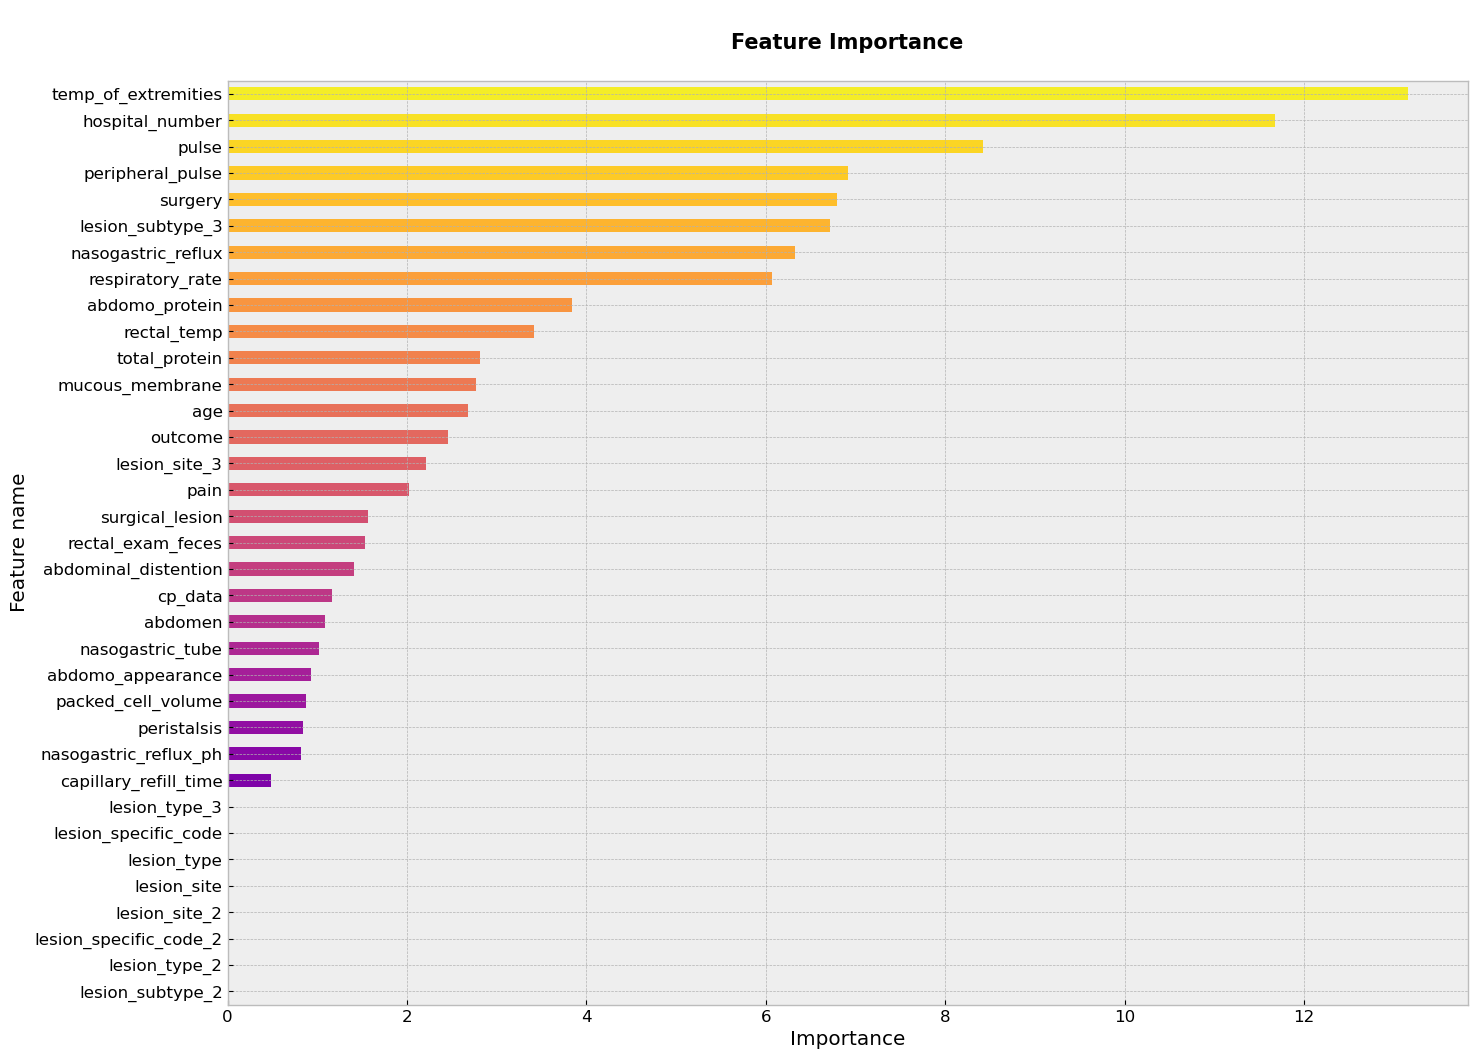

In [47]:
feature_importance = pd.DataFrame(data = {'feature': train.columns[:-1], 'importance': model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=True)

feature_importance.plot(kind='barh', x='feature', y='importance', legend=False, color=sns.color_palette('plasma', n_colors=len(feature_importance)), figsize=(16, 12))

plt.xlabel('Importance')
plt.ylabel('Feature name')
plt.title('\nFeature Importance\n', fontsize=15)
plt.show()

In [48]:
X_test = pd.DataFrame(data=transformer.transform(test), columns=transformer.get_feature_names_out(), index=test.index)

In [49]:
predictions = []
for model in models:
    predictions.append(model.predict(X_test).ravel()) # CatBoostClassifier's predictions are of shape (n ,1) and not (n, ) like other models so we have to use .ravel()

# Mode doesn't work on python lists only on ndarray (numpy arrays)
predictions = np.array(predictions)

# Take the most frequent prediction out of 3 models
final_predictions, _ = stats.mode(predictions, axis=0)

final_predictions.shape

(1, 824)

## 8. SUBMISSION

In [50]:
submission = pd.read_csv('../input/playground-series-s3e22/sample_submission.csv')
submission['outcome'] = target_encoder.inverse_transform(final_predictions.reshape(-1, 1)).ravel()

print(submission)
submission.to_csv('submission.csv', index = False)

       id     outcome
0    1235       lived
1    1236        died
2    1237       lived
3    1238  euthanized
4    1239       lived
..    ...         ...
819  2054        died
820  2055  euthanized
821  2056        died
822  2057       lived
823  2058       lived

[824 rows x 2 columns]
